In [29]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
import pickle
import time
import gc

from iteration_utilities import flatten
from torch.utils.data import Dataset, DataLoader
from scipy.stats import mode

In [30]:
!pip install iteration_utilities

In [31]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/10-gym-exercises-with-615-abstracted-features/RecGym.csv


In [32]:

class RecGym_DATA(Dataset):
    def __init__(self, root_path, window_size, overlap_size, transform=None):
        """
        root_path : Root directory of the data set
        window_size : Size of the window in seconds
        overlap_size : Size of the overlap in seconds
        transform : Optional transform to be applied on a sample
        """
        self.root_path = root_path
        self.window_size = window_size
        self.overlap_size = overlap_size
        self.transform = transform
        self.used_cols = ["A_x", "A_y", "A_z", "G_x", "G_y", "G_z", "C_1", "Workout", "Subject", "Session"]
        self.label_map = {
            "Adductor": 1, "ArmCurl": 2, "BenchPress": 3, "LegCurl": 4, "LegPress": 5, "Null": 6, 
            "Riding": 7, "RopeSkipping": 8, "Running": 9, "Squat": 10, "StairClimber": 11, "Walking": 12
        }
        self.labelToId = {v: k for v, k in self.label_map.items()}
        self.data_x, self.data_y, self.subjects, self.sessions = self.load_all_the_data()

    def load_all_the_data(self):
        print(" ----------------------- load all the data -------------------")
        df_all = pd.read_csv(os.path.join(self.root_path, "RecGym.csv"))
        df_all = df_all[self.used_cols]
        df_all.dropna(inplace=True)
        df_all["Workout"] = df_all["Workout"].map(self.labelToId)
        data_y = df_all["Workout"].values
        data_x = df_all.drop(columns=["Workout", "Subject", "Session"]).values
        subjects = df_all["Subject"].values
        sessions = df_all["Session"].values

        # Segment the data into windows
        window_size_samples = int(self.window_size * 20)  # 20Hz sampling rate
        overlap_size_samples = int(self.overlap_size * 20)
        step_size = window_size_samples - overlap_size_samples

        segmented_data_x = []
        segmented_data_y = []
        segmented_subjects = []
        segmented_sessions = []

        for start in range(0, len(data_x) - window_size_samples + 1, step_size):
            end = start + window_size_samples
            window_x = data_x[start:end]
            window_y = data_y[start:end]
            window_subjects = subjects[start:end]
            window_sessions = sessions[start:end]
            segmented_data_x.append(window_x)
            segmented_data_y.append(mode(window_y)[0])  # Most common label in the window
            segmented_subjects.append(mode(window_subjects)[0])  # Most common subject in the window
            segmented_sessions.append(mode(window_sessions)[0])  # Most common session in the window


        self.data_x = np.array(segmented_data_x)
        self.data_y = np.array(segmented_data_y)
        self.subjects = np.array(segmented_subjects)
        self.sessions = np.array(segmented_sessions)

        print(self.data_x.shape)
        print(self.data_y.shape)
        return self.data_x, self.data_y, self.subjects, self.sessions

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        sample = self.data_x[idx]
        label = self.data_y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

def load_data(root_path, batch_size, window_size, overlap_size, training_strategy, fold):
    dataset = RecGym_DATA(root_path, window_size, overlap_size)
    
    if training_strategy == "LOUO":
        if fold < 1 or fold > 10:
            raise ValueError("Fold number for LOUO must be between 1 and 10.")
        train_idx = np.where(dataset.subjects != fold)[0]
        test_idx = np.where(dataset.subjects == fold)[0]
    elif training_strategy == "LOSO":
        if fold < 1 or fold > 5:
            raise ValueError("Fold number for LOSO must be between 1 and 5.")
        train_idx = np.where(dataset.sessions != fold)[0]
        test_idx = np.where(dataset.sessions == fold)[0]
    else:
        raise ValueError("Invalid training strategy. Choose either 'LOUO' or 'LOSO'.")

    train_x, train_y = dataset.data_x[train_idx], dataset.data_y[train_idx]
    test_x, test_y = dataset.data_x[test_idx], dataset.data_y[test_idx]

    train_dataset = CustomDataset(train_x, train_y, dataset.transform)
    test_dataset = CustomDataset(test_x, test_y, dataset.transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

class CustomDataset(Dataset):
    def __init__(self, data_x, data_y, transform=None):
        self.data_x = data_x
        self.data_y = data_y
        self.transform = transform

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        sample = self.data_x[idx]
        label = self.data_y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

def main():
    root_path = "/kaggle/input/10-gym-exercises-with-615-abstracted-features"
    batch_size = 64
    window_size = 4  # Window size in seconds
    overlap_size = 2  # Overlap size in seconds
    training_strategy = "LOUO"  # Training strategy: "LOUO"(Leave-One-User-Out) or "LOSO"(Leave-One-Session-Out)
    fold = 1  # Fold number for cross-validation  (1-10 for LOUO, 1-5 for LOSO)

    train_loader, test_loader = load_data(root_path, batch_size, window_size, overlap_size, training_strategy, fold)

    for i, (samples, labels) in enumerate(train_loader):
        print(f"Train Batch {i+1}")
        print("Samples:", samples)
        print("Labels:", labels)
        if i == 0:  # Print only the first batch for brevity
            break

    for i, (samples, labels) in enumerate(test_loader):
        print(f"Test Batch {i+1}")
        print("Samples:", samples)
        print("Labels:", labels)
        if i == 0:  # Print only the first batch for brevity
            break

if __name__ == '__main__':
    main()

 ----------------------- load all the data -------------------
(117582, 80, 7)
(117582,)
Train Batch 1
Samples: tensor([[[0.4959, 0.5030, 0.4501,  ..., 0.5030, 0.5119, 0.5632],
         [0.4830, 0.2923, 0.4085,  ..., 0.4863, 0.5267, 0.6052],
         [0.5070, 0.4925, 0.4964,  ..., 0.4809, 0.5036, 0.5752],
         ...,
         [0.5068, 0.5005, 0.4899,  ..., 0.4699, 0.4629, 0.5945],
         [0.5089, 0.4840, 0.5061,  ..., 0.4675, 0.4634, 0.5851],
         [0.5151, 0.4886, 0.5100,  ..., 0.4593, 0.4597, 0.5401]],

        [[0.5059, 0.5011, 0.5019,  ..., 0.4792, 0.5268, 0.5556],
         [0.5065, 0.4978, 0.5074,  ..., 0.4986, 0.5207, 0.5428],
         [0.4695, 0.5010, 0.4778,  ..., 0.4555, 0.5189, 0.5285],
         ...,
         [0.5190, 0.5012, 0.4926,  ..., 0.5036, 0.5020, 0.5061],
         [0.5091, 0.4975, 0.4960,  ..., 0.5002, 0.5009, 0.5010],
         [0.5214, 0.4971, 0.4936,  ..., 0.4941, 0.5011, 0.4888]],

        [[0.4986, 0.5014, 0.4986,  ..., 0.5020, 0.5002, 0.5009],
         [0

RECGYM DATASET VISUALIZATION - REAL DATA

[1] Loading and Preparing Real RecGym Data...
--------------------------------------------------------------------------------
✓ Loading data from: /kaggle/input/10-gym-exercises-with-615-abstracted-features/RecGym.csv
✓ Raw data shape: (4703320, 11)
✓ Clean data shape: (4703320, 10)
✓ Number of samples: 4,703,320
✓ Unique workouts: 12
✓ Unique subjects: 10
✓ Unique sessions: 5

✓ Segmenting data into windows...
  Window size: 4s (80 samples)
  Overlap size: 2s (40 samples)
  Step size: 40 samples
✓ Created 117,582 windows
✓ Window data shape: (117582, 80, 7)
✓ Window labels shape: (117582,)

📊 Workout Distribution:
   1. Adductor       :  3,650 samples ( 3.10%)
   2. ArmCurl        :  3,995 samples ( 3.40%)
   3. BenchPress     :  3,540 samples ( 3.01%)
   4. LegCurl        :  3,464 samples ( 2.95%)
   5. LegPress       :  4,158 samples ( 3.54%)
   6. Null           : 65,150 samples (55.41%)
   7. Riding         :  6,568 samples ( 5.59%)
   8.

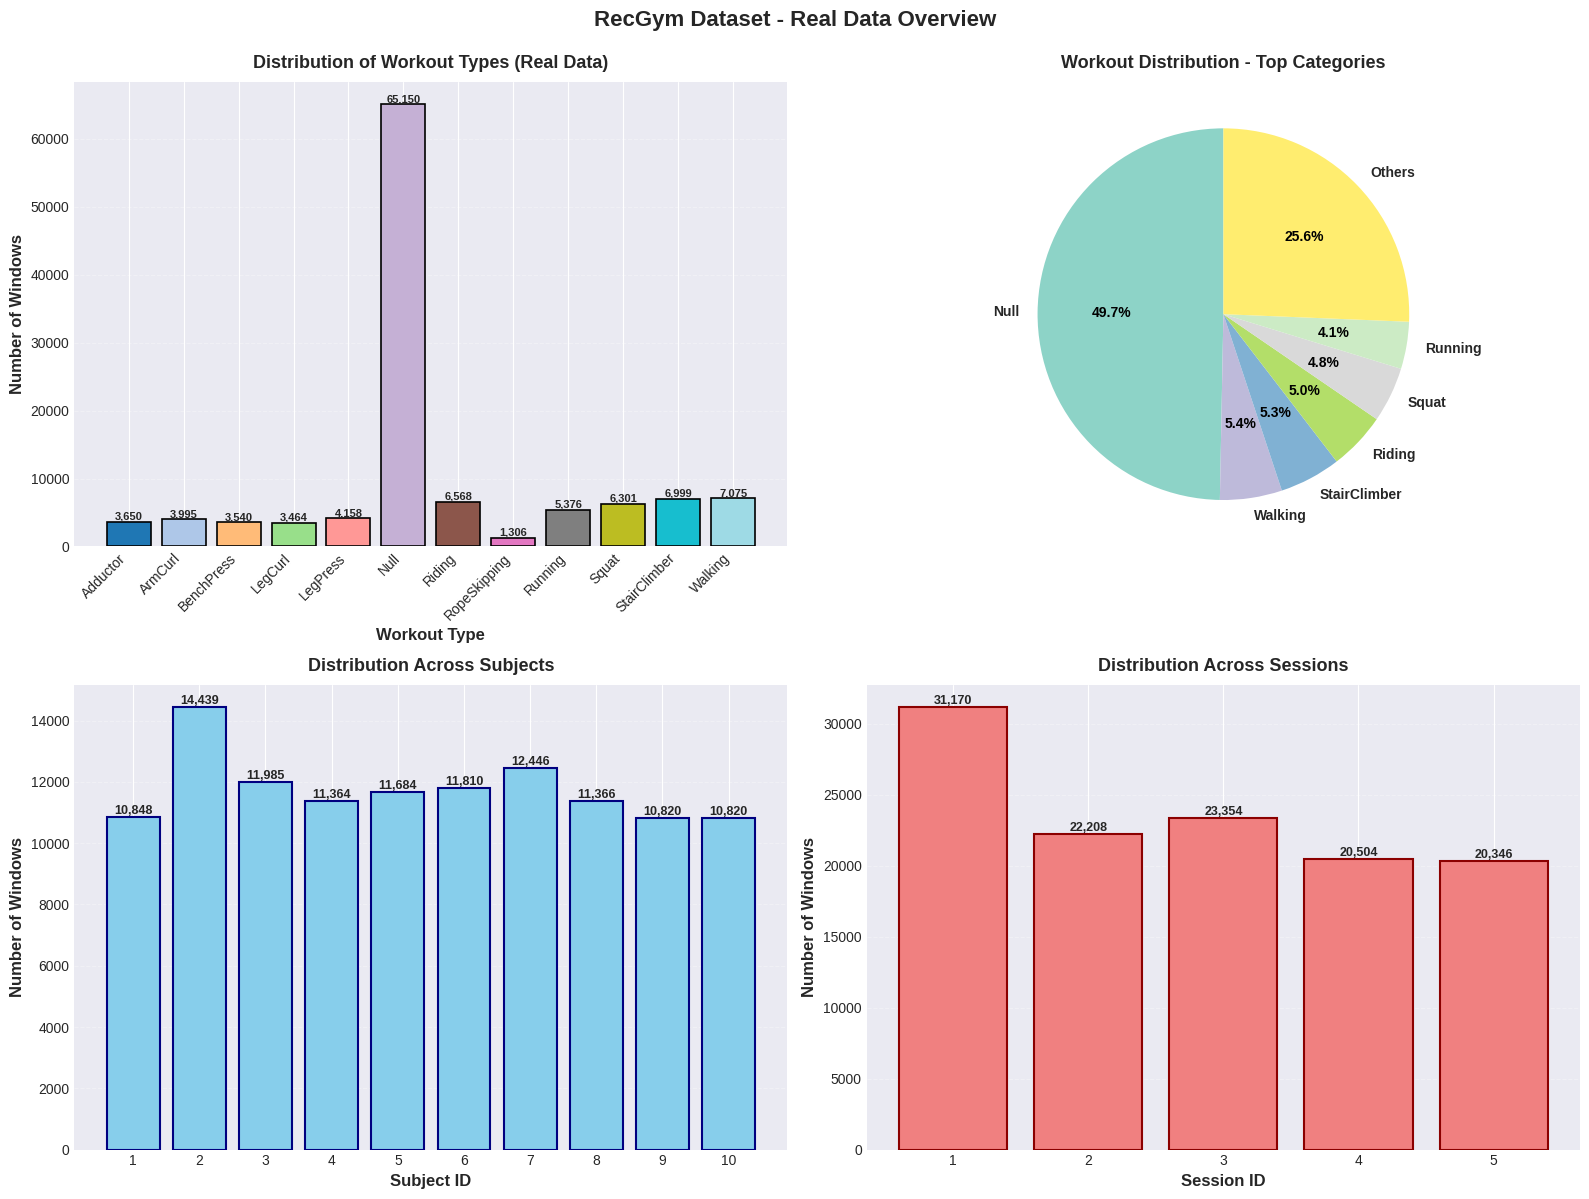

✓ Overview visualization completed!

[3] Creating Cross-Analysis Heatmaps...
--------------------------------------------------------------------------------


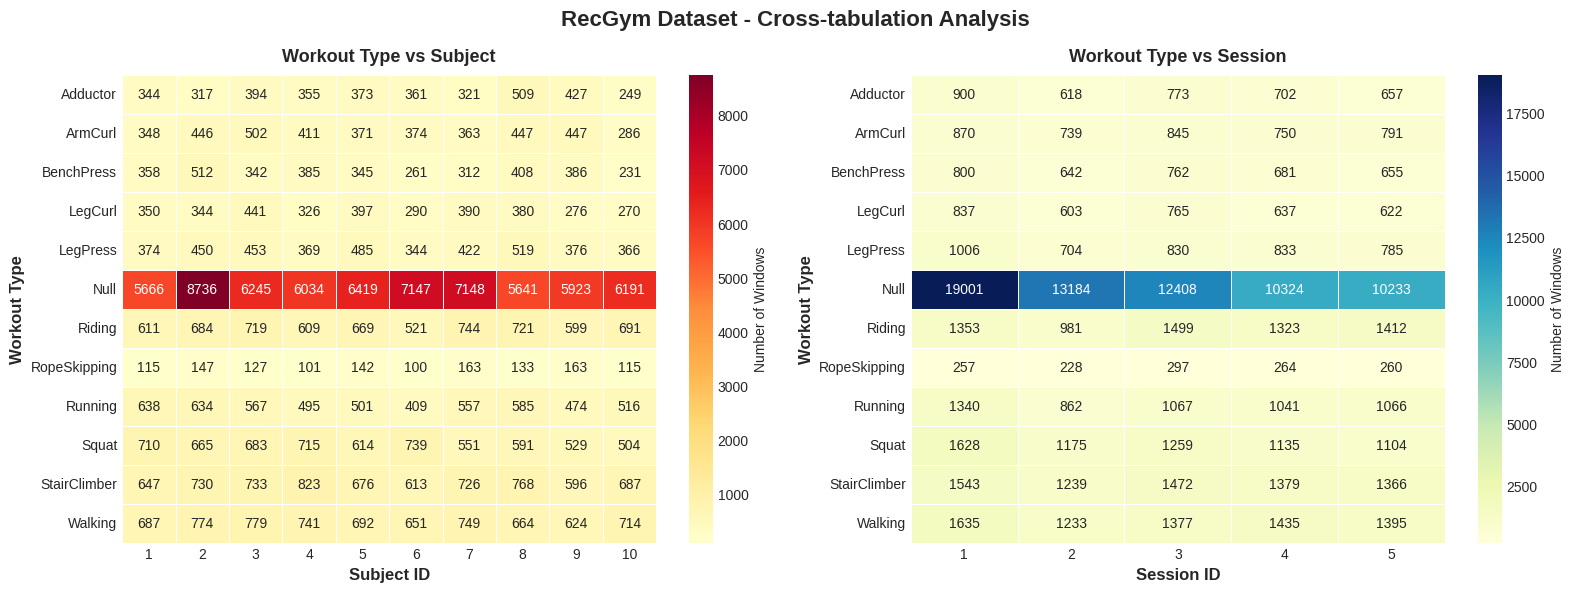

✓ Cross-analysis heatmaps completed!

[4] Creating Real Sensor Data Visualization...
--------------------------------------------------------------------------------


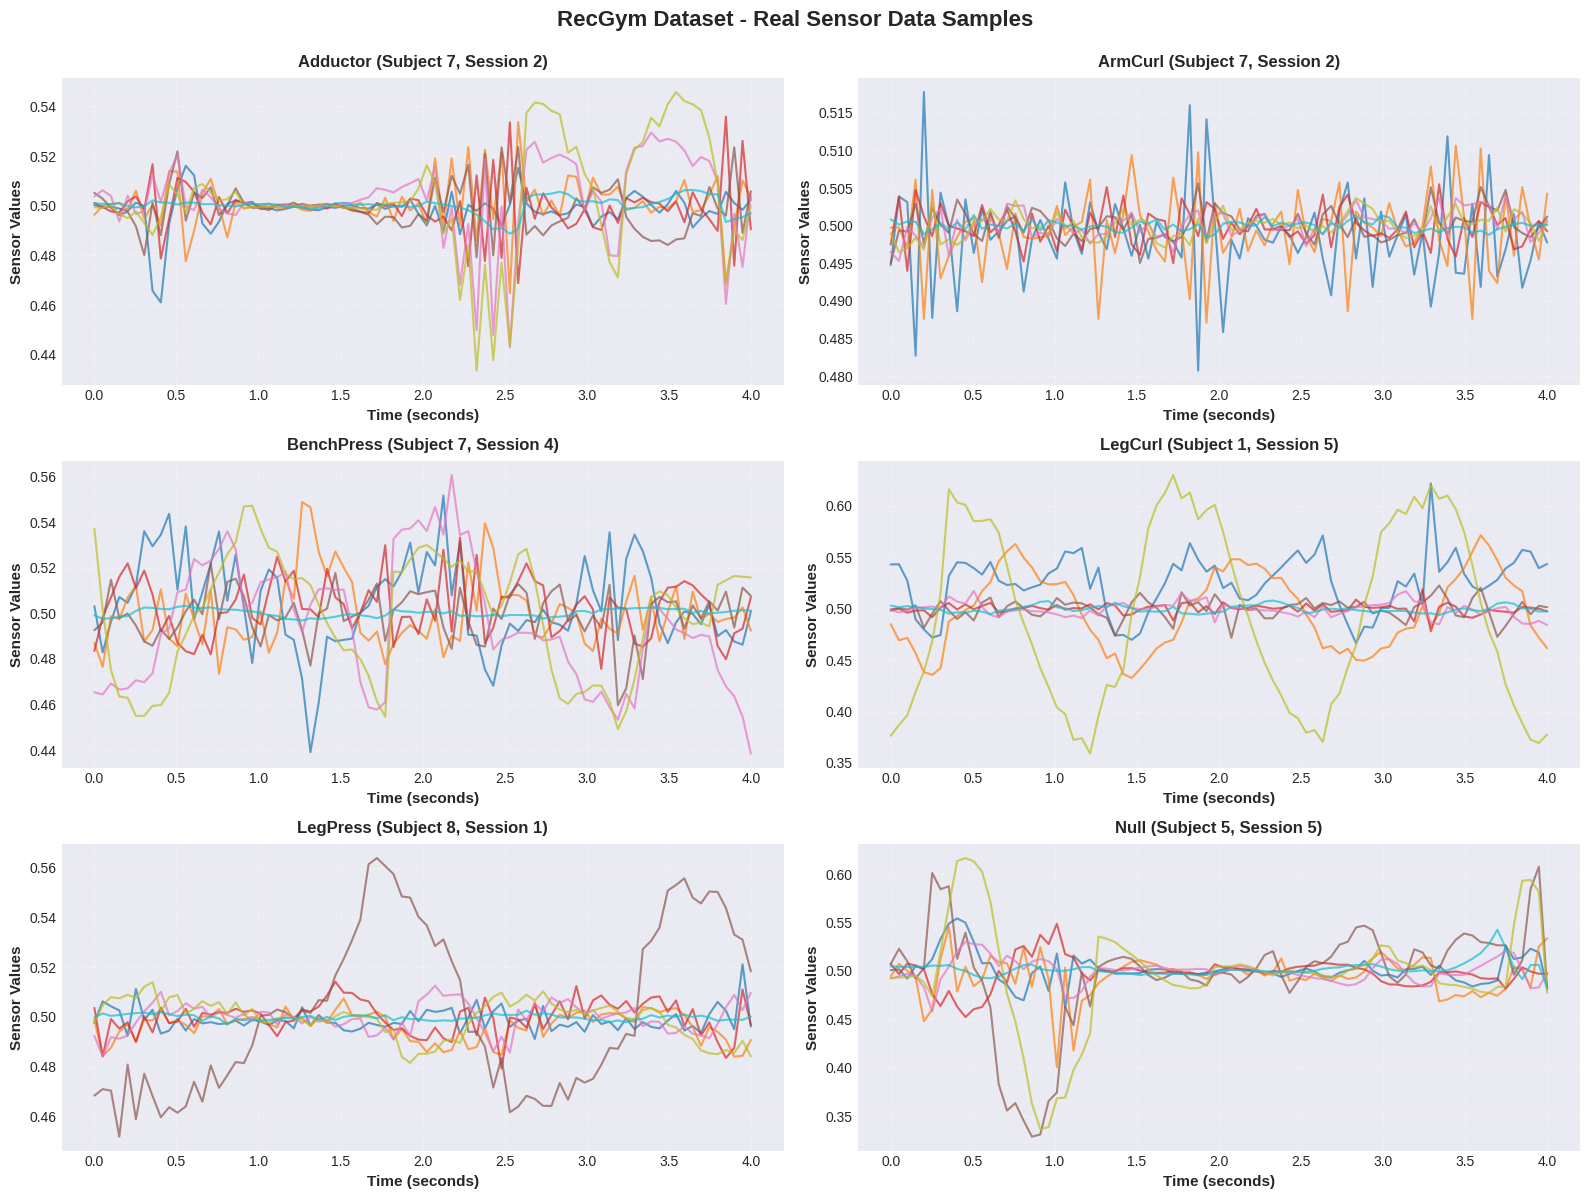

✓ Real sensor data visualization completed!

[5] Dataset Summary...
--------------------------------------------------------------------------------

📊 DATASET SUMMARY:
  • Total Windows: 117,582
  • Window Duration: 4 seconds (80 samples)
  • Overlap Duration: 2 seconds (40 samples)
  • Features per Window: 80 sensor channels
  • Samples per Window: 7 timesteps
  • Unique Workouts: 12
  • Unique Subjects: 10
  • Unique Sessions: 5

📈 ADDITIONAL STATISTICS:
  • Workout with most samples: Null (65,150 windows)
  • Most active subject: Subject 2 (14,439 windows)
  • Most recorded session: Session 1 (31,170 windows)

✅ All visualizations completed successfully!


In [33]:
# data visualisasi
warnings.filterwarnings('ignore')

# Konfigurasi visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


class RecGymDatasetLoader:
    """Kelas untuk memuat dan memproses dataset RecGym"""
    def __init__(self, root_path, window_size=4, overlap_size=2, sampling_rate=20):
        self.root_path = root_path
        self.window_size = window_size
        self.overlap_size = overlap_size
        self.sampling_rate = sampling_rate
        
        self.label_map = {
            "Adductor": 1, "ArmCurl": 2, "BenchPress": 3, "LegCurl": 4,
            "LegPress": 5, "Null": 6, "Riding": 7, "RopeSkipping": 8,
            "Running": 9, "Squat": 10, "StairClimber": 11, "Walking": 12
        }
        
        self.id_to_label = {v: k for k, v in self.label_map.items()}
        
    def load_and_preprocess(self):
        """Memuat dan memproses dataset RecGym"""
        print("\n[1] Loading and Preparing Real RecGym Data...")
        print("-" * 80)
        
        # Load dataset asli
        file_path = os.path.join(self.root_path, "RecGym.csv")
        print(f"✓ Loading data from: {file_path}")
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        df_all = pd.read_csv(file_path)
        print(f"✓ Raw data shape: {df_all.shape}")
        
        # Kolom yang digunakan
        used_cols = ["A_x", "A_y", "A_z", "G_x", "G_y", "G_z", "C_1", "Workout", "Subject", "Session"]
        
        # Pastikan semua kolom ada
        missing_cols = [col for col in used_cols if col not in df_all.columns]
        if missing_cols:
            print(f"⚠ Warning: Missing columns: {missing_cols}")
            print(f"  Available columns: {list(df_all.columns)}")
            # Hanya ambil kolom yang ada
            used_cols = [col for col in used_cols if col in df_all.columns]
        
        df_all = df_all[used_cols]
        df_all.dropna(inplace=True)
        
        # Map label workout ke ID numerik
        df_all["Workout"] = df_all["Workout"].map(self.label_map)
        
        # Ekstrak data
        data_y = df_all["Workout"].values
        data_x = df_all.drop(columns=["Workout", "Subject", "Session"]).values
        subjects = df_all["Subject"].values
        sessions = df_all["Session"].values
        
        print(f"✓ Clean data shape: {df_all.shape}")
        print(f"✓ Number of samples: {len(df_all):,}")
        print(f"✓ Unique workouts: {df_all['Workout'].nunique()}")
        print(f"✓ Unique subjects: {df_all['Subject'].nunique()}")
        print(f"✓ Unique sessions: {df_all['Session'].nunique()}")
        
        # Segmentasi data ke windows
        window_size_samples = int(self.window_size * self.sampling_rate)
        overlap_size_samples = int(self.overlap_size * self.sampling_rate)
        step_size = window_size_samples - overlap_size_samples
        
        print(f"\n✓ Segmenting data into windows...")
        print(f"  Window size: {self.window_size}s ({window_size_samples} samples)")
        print(f"  Overlap size: {self.overlap_size}s ({overlap_size_samples} samples)")
        print(f"  Step size: {step_size} samples")
        
        segmented_data_x = []
        segmented_data_y = []
        segmented_subjects = []
        segmented_sessions = []
        
        total_windows = 0
        for start in range(0, len(data_x) - window_size_samples + 1, step_size):
            end = start + window_size_samples
            window_x = data_x[start:end]
            window_y = data_y[start:end]
            window_subjects = subjects[start:end]
            window_sessions = sessions[start:end]
            
            # Gunakan mode untuk mendapatkan label, subject, dan session yang dominan dalam window
            segmented_data_x.append(window_x)
            segmented_data_y.append(mode(window_y)[0])
            segmented_subjects.append(mode(window_subjects)[0])
            segmented_sessions.append(mode(window_sessions)[0])
            total_windows += 1
        
        # Konversi ke numpy arrays
        segmented_data_x = np.array(segmented_data_x)
        segmented_data_y = np.array(segmented_data_y)
        segmented_subjects = np.array(segmented_subjects)
        segmented_sessions = np.array(segmented_sessions)
        
        print(f"✓ Created {total_windows:,} windows")
        print(f"✓ Window data shape: {segmented_data_x.shape}")
        print(f"✓ Window labels shape: {segmented_data_y.shape}")
        
        return segmented_data_x, segmented_data_y, segmented_subjects, segmented_sessions, df_all


class DatasetAnalyzer:
    """Kelas untuk menganalisis dataset"""
    def __init__(self, data_y, subjects, sessions, id_to_label):
        self.data_y = data_y
        self.subjects = subjects
        self.sessions = sessions
        self.id_to_label = id_to_label
        
        # Buat DataFrame untuk analisis
        self.df_stats = pd.DataFrame({
            'Workout': data_y,
            'Subject': subjects,
            'Session': sessions
        })
        
    def print_distribution_statistics(self):
        """Mencetak statistik distribusi"""
        print("\n📊 Workout Distribution:")
        workout_counts = self.df_stats['Workout'].value_counts().sort_index()
        
        total_samples = len(self.df_stats)
        for workout_id, count in workout_counts.items():
            workout_name = self.id_to_label.get(workout_id, f"Unknown_{workout_id}")
            percentage = (count / total_samples) * 100
            print(f"  {workout_id:2d}. {workout_name:15s}: {count:6,} samples ({percentage:5.2f}%)")
        
        print(f"\n👥 Subject Distribution:")
        subject_counts = self.df_stats['Subject'].value_counts().sort_index()
        
        for subject_id, count in subject_counts.items():
            percentage = (count / total_samples) * 100
            print(f"  Subject {subject_id:2d}: {count:6,} samples ({percentage:5.2f}%)")
        
        print(f"\n📅 Session Distribution:")
        session_counts = self.df_stats['Session'].value_counts().sort_index()
        
        for session_id, count in session_counts.items():
            percentage = (count / total_samples) * 100
            print(f"  Session {session_id:2d}: {count:6,} samples ({percentage:5.2f}%)")
        
        return workout_counts, subject_counts, session_counts


class DatasetVisualizer:
    """Kelas untuk visualisasi dataset"""
    def __init__(self, df_stats, id_to_label, raw_data=None):
        self.df_stats = df_stats
        self.id_to_label = id_to_label
        self.raw_data = raw_data
    
    def create_overview_visualization(self):
        """Membuat visualisasi overview dataset"""
        print("\n[2] Creating Dataset Overview Visualization...")
        print("-" * 80)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('RecGym Dataset - Real Data Overview', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        self._plot_workout_distribution(axes[0, 0])
        self._plot_workout_pie_chart(axes[0, 1])
        self._plot_subject_distribution(axes[1, 0])
        self._plot_session_distribution(axes[1, 1])
        
        plt.tight_layout()
        plt.show()
        print("✓ Overview visualization completed!")
    
    def _plot_workout_distribution(self, ax):
        """Plot distribusi latihan"""
        workout_counts = self.df_stats['Workout'].value_counts().sort_index()
        workout_names = [self.id_to_label.get(i, f"Unknown_{i}") for i in workout_counts.index]
        workout_values = [workout_counts[i] for i in workout_counts.index]
        colors = plt.cm.tab20(np.linspace(0, 1, len(workout_names)))
        
        bars = ax.bar(range(len(workout_names)), workout_values, 
                     color=colors, edgecolor='black', linewidth=1.2)
        
        ax.set_xlabel('Workout Type', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Windows', fontsize=12, fontweight='bold')
        ax.set_title('Distribution of Workout Types (Real Data)', 
                    fontsize=13, fontweight='bold', pad=10)
        ax.set_xticks(range(len(workout_names)))
        ax.set_xticklabels(workout_names, rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        for bar, value in zip(bars, workout_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{value:,}', ha='center', va='bottom', 
                   fontsize=8, fontweight='bold')
    
    def _plot_workout_pie_chart(self, ax):
        """Plot pie chart distribusi latihan"""
        workout_counts = self.df_stats['Workout'].value_counts().sort_index()
        top_n = min(6, len(workout_counts))
        top_workouts = workout_counts.nlargest(top_n)
        other_count = workout_counts.iloc[top_n:].sum() if len(workout_counts) > top_n else 0
        
        pie_labels = [self.id_to_label.get(i, f"Unknown_{i}") for i in top_workouts.index]
        pie_values = top_workouts.values.tolist()
        
        if other_count > 0:
            pie_labels.append('Others')
            pie_values.append(other_count)
        
        colors_pie = plt.cm.Set3(np.linspace(0, 1, len(pie_labels)))
        wedges, texts, autotexts = ax.pie(pie_values, labels=pie_labels, autopct='%1.1f%%',
                                         colors=colors_pie, startangle=90,
                                         textprops={'fontsize': 10, 'fontweight': 'bold'})
        
        # Buat autotext lebih jelas
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
        
        ax.set_title('Workout Distribution - Top Categories', 
                    fontsize=13, fontweight='bold', pad=10)
    
    def _plot_subject_distribution(self, ax):
        """Plot distribusi subjek"""
        subject_counts = self.df_stats['Subject'].value_counts().sort_index()
        subject_ids = sorted(subject_counts.index)
        subject_values = [subject_counts[i] for i in subject_ids]
        
        bars = ax.bar(subject_ids, subject_values, color='skyblue', 
                     edgecolor='navy', linewidth=1.5)
        
        ax.set_xlabel('Subject ID', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Windows', fontsize=12, fontweight='bold')
        ax.set_title('Distribution Across Subjects', 
                    fontsize=13, fontweight='bold', pad=10)
        ax.set_xticks(subject_ids)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
    
    def _plot_session_distribution(self, ax):
        """Plot distribusi sesi"""
        session_counts = self.df_stats['Session'].value_counts().sort_index()
        session_ids = sorted(session_counts.index)
        session_values = [session_counts[i] for i in session_ids]
        
        bars = ax.bar(session_ids, session_values, color='lightcoral', 
                     edgecolor='darkred', linewidth=1.5)
        
        ax.set_xlabel('Session ID', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Windows', fontsize=12, fontweight='bold')
        ax.set_title('Distribution Across Sessions', 
                    fontsize=13, fontweight='bold', pad=10)
        ax.set_xticks(session_ids)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
    
    def create_cross_analysis_heatmaps(self):
        """Membuat heatmap untuk analisis silang"""
        print("\n[3] Creating Cross-Analysis Heatmaps...")
        print("-" * 80)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('RecGym Dataset - Cross-tabulation Analysis', 
                    fontsize=16, fontweight='bold')
        
        # Heatmap 1: Workout vs Subject
        workout_subject_crosstab = pd.crosstab(
            self.df_stats['Workout'], 
            self.df_stats['Subject']
        )
        workout_subject_crosstab.index = [
            self.id_to_label.get(i, f"Unknown_{i}") for i in workout_subject_crosstab.index
        ]
        
        sns.heatmap(workout_subject_crosstab, annot=True, fmt='d', 
                   cmap='YlOrRd', ax=axes[0], 
                   cbar_kws={'label': 'Number of Windows'}, linewidths=0.5)
        axes[0].set_title('Workout Type vs Subject', 
                         fontsize=13, fontweight='bold', pad=10)
        axes[0].set_xlabel('Subject ID', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Workout Type', fontsize=12, fontweight='bold')
        
        # Heatmap 2: Workout vs Session
        workout_session_crosstab = pd.crosstab(
            self.df_stats['Workout'], 
            self.df_stats['Session']
        )
        workout_session_crosstab.index = [
            self.id_to_label.get(i, f"Unknown_{i}") for i in workout_session_crosstab.index
        ]
        
        sns.heatmap(workout_session_crosstab, annot=True, fmt='d', 
                   cmap='YlGnBu', ax=axes[1], 
                   cbar_kws={'label': 'Number of Windows'}, linewidths=0.5)
        axes[1].set_title('Workout Type vs Session', 
                         fontsize=13, fontweight='bold', pad=10)
        axes[1].set_xlabel('Session ID', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Workout Type', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        print("✓ Cross-analysis heatmaps completed!")
    
    def create_sensor_data_visualization(self, windowed_data, sample_indices=None):
        """Membuat visualisasi data sensor aktual"""
        print("\n[4] Creating Real Sensor Data Visualization...")
        print("-" * 80)
        
        if sample_indices is None:
            # Ambil sample acak untuk setiap workout
            sample_indices = []
            unique_workouts = np.unique(self.df_stats['Workout'])
            
            for workout_id in unique_workouts:
                workout_indices = np.where(self.df_stats['Workout'] == workout_id)[0]
                if len(workout_indices) > 0:
                    sample_idx = np.random.choice(workout_indices, 1)[0]
                    sample_indices.append(sample_idx)
            
            # Batasi maksimal 6 sample untuk visualisasi
            sample_indices = sample_indices[:6]
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        fig.suptitle('RecGym Dataset - Real Sensor Data Samples', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        for idx, sample_idx in enumerate(sample_indices):
            if idx >= 6:  # Maksimal 6 plot
                break
                
            ax = axes[idx // 2, idx % 2]
            self._plot_single_sensor_window(ax, windowed_data, sample_idx)
        
        # Sembunyikan axes yang tidak terpakai
        for idx in range(len(sample_indices), 6):
            ax = axes[idx // 2, idx % 2]
            ax.axis('off')
            if idx == len(sample_indices):
                ax.text(0.5, 0.5, f'Only {len(sample_indices)} unique workouts available', 
                       ha='center', va='center', fontsize=12, 
                       transform=ax.transAxes, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        print("✓ Real sensor data visualization completed!")
    
    def _plot_single_sensor_window(self, ax, windowed_data, sample_idx):
        """Plot data sensor untuk satu window"""
        window_data = windowed_data[sample_idx]
        workout_id = self.df_stats.iloc[sample_idx]['Workout']
        workout_name = self.id_to_label.get(workout_id, f"Unknown_{workout_id}")
        subject_id = self.df_stats.iloc[sample_idx]['Subject']
        session_id = self.df_stats.iloc[sample_idx]['Session']
        
        time_points = np.linspace(0, 4, len(window_data))  # 4 detik window
        
        # Plot 7 sensor channels (A_x, A_y, A_z, G_x, G_y, G_z, C_1)
        sensor_labels = ['Accel X', 'Accel Y', 'Accel Z', 
                        'Gyro X', 'Gyro Y', 'Gyro Z', 'Compass 1']
        colors = plt.cm.tab10(np.linspace(0, 1, 7))
        
        for i in range(7):
            if i < window_data.shape[1]:  # Pastikan ada cukup kolom
                ax.plot(time_points, window_data[:, i], 
                       label=sensor_labels[i], linewidth=1.5, alpha=0.7, color=colors[i])
        
        ax.set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Sensor Values', fontsize=11, fontweight='bold')
        ax.set_title(f'{workout_name} (Subject {subject_id}, Session {session_id})', 
                    fontsize=12, fontweight='bold', pad=8)
        
        # Hanya tampilkan legend jika tidak terlalu penuh
        if len(sensor_labels) <= 4:
            ax.legend(loc='upper right', fontsize=8)
        
        ax.grid(True, alpha=0.3, linestyle='--')


def print_dataset_summary(windowed_data, df_stats, config):
    """Mencetak summary dataset"""
    print("\n[5] Dataset Summary...")
    print("-" * 80)
    
    print("\n📊 DATASET SUMMARY:")
    print(f"  • Total Windows: {len(windowed_data):,}")
    print(f"  • Window Duration: {config.window_size} seconds ({config.window_size * config.sampling_rate} samples)")
    print(f"  • Overlap Duration: {config.overlap_size} seconds ({config.overlap_size * config.sampling_rate} samples)")
    print(f"  • Features per Window: {windowed_data.shape[1]} sensor channels")
    print(f"  • Samples per Window: {windowed_data.shape[2]} timesteps")
    print(f"  • Unique Workouts: {df_stats['Workout'].nunique()}")
    print(f"  • Unique Subjects: {df_stats['Subject'].nunique()}")
    print(f"  • Unique Sessions: {df_stats['Session'].nunique()}")
    
    # Statistik tambahan
    print("\n📈 ADDITIONAL STATISTICS:")
    print(f"  • Workout with most samples: {config.id_to_label[df_stats['Workout'].value_counts().idxmax()]} "
          f"({df_stats['Workout'].value_counts().max():,} windows)")
    print(f"  • Most active subject: Subject {df_stats['Subject'].value_counts().idxmax()} "
          f"({df_stats['Subject'].value_counts().max():,} windows)")
    print(f"  • Most recorded session: Session {df_stats['Session'].value_counts().idxmax()} "
          f"({df_stats['Session'].value_counts().max():,} windows)")


def main():
    """Fungsi utama"""
    print("=" * 80)
    print("RECGYM DATASET VISUALIZATION - REAL DATA")
    print("=" * 80)
    
    # Konfigurasi
    root_path = "/kaggle/input/10-gym-exercises-with-615-abstracted-features"  # Ganti dengan path dataset Anda
    window_size = 4  # detik
    overlap_size = 2  # detik
    sampling_rate = 20  # Hz
    
    try:
        # 1. Load dataset asli
        loader = RecGymDatasetLoader(root_path, window_size, overlap_size, sampling_rate)
        windowed_data, labels, subjects, sessions, raw_df = loader.load_and_preprocess()
        
        # 2. Analisis distribusi
        analyzer = DatasetAnalyzer(labels, subjects, sessions, loader.id_to_label)
        workout_counts, subject_counts, session_counts = analyzer.print_distribution_statistics()
        
        # 3. Visualisasi
        visualizer = DatasetVisualizer(analyzer.df_stats, loader.id_to_label, raw_df)
        
        # Visualisasi 1: Overview
        visualizer.create_overview_visualization()
        
        # Visualisasi 2: Heatmaps
        visualizer.create_cross_analysis_heatmaps()
        
        # Visualisasi 3: Data sensor aktual
        visualizer.create_sensor_data_visualization(windowed_data)
        
        # 4. Summary
        print_dataset_summary(windowed_data, analyzer.df_stats, loader)
        
        print("\n✅ All visualizations completed successfully!")
        print("=" * 80)
        
    except FileNotFoundError as e:
        print(f"\n❌ Error: {e}")
        print("Please check the dataset path and ensure RecGym.csv exists.")
        print("=" * 80)
    except Exception as e:
        print(f"\n❌ Unexpected error: {e}")
        print("=" * 80)


if __name__ == "__main__":
    main()

In [34]:
# data_processing

warnings.filterwarnings('ignore')
np.random.seed(42)


class RecGymDataProcessor:
    """Kelas untuk memproses dataset RecGym secara komprehensif"""
    
    def __init__(self, root_path, window_size=4, overlap_size=2, sampling_rate=20):
        self.root_path = root_path
        self.window_size = window_size
        self.overlap_size = overlap_size
        self.sampling_rate = sampling_rate
        
        # Mapping label workout
        self.label_map = {
            "Adductor": 0, "ArmCurl": 1, "BenchPress": 2, "LegCurl": 3,
            "LegPress": 4, "Riding": 5, "RopeSkipping": 6, "Running": 7,
            "Squat": 8, "StairClimber": 9, "Walking": 10
        }
        
        # Reverse mapping untuk interpretasi
        self.id_to_label = {v: k for k, v in self.label_map.items()}
        
    def load_and_preprocess(self, remove_null=True, balance_classes=True, 
                           test_size=0.2, val_size=0.1, random_state=42):
        """
        Memuat dan memproses dataset secara lengkap
        Returns: X_train, X_val, X_test, y_train, y_val, y_test, label_mapping
        """
        print("=" * 80)
        print("RECGYM DATA PROCESSING PIPELINE")
        print("=" * 80)
        
        # Step 1: Load raw data
        print("\n[1] Loading Raw Data...")
        print("-" * 80)
        raw_data = self._load_raw_data()
        
        # Step 2: Preprocess data
        print("\n[2] Preprocessing Data...")
        print("-" * 80)
        preprocessed_data = self._preprocess_data(raw_data, remove_null)
        
        # Step 3: Create windows
        print("\n[3] Creating Time Windows...")
        print("-" * 80)
        windowed_data = self._create_windows(preprocessed_data)
        
        # Step 4: Balance classes
        if balance_classes:
            print("\n[4] Balancing Classes...")
            print("-" * 80)
            windowed_data = self._balance_classes(windowed_data)
        
        # Step 5: Split data
        print("\n[5] Splitting Data...")
        print("-" * 80)
        splits = self._split_data(windowed_data, test_size, val_size, random_state)
        
        # Step 6: Prepare final datasets
        print("\n[6] Preparing Final Datasets...")
        print("-" * 80)
        final_data = self._prepare_final_datasets(splits)
        
        print("\n" + "=" * 80)
        print("✅ DATA PROCESSING COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        
        return final_data
    
    def _load_raw_data(self):
        """Memuat data mentah dari CSV"""
        file_path = os.path.join(self.root_path, "RecGym.csv")
        print(f"✓ Loading from: {file_path}")
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        df_all = pd.read_csv(file_path)
        print(f"✓ Raw data shape: {df_all.shape}")
        print(f"✓ Columns: {list(df_all.columns)}")
        
        return df_all
    
    def _preprocess_data(self, df, remove_null):
        """Preprocessing data: cleaning, filtering, mapping"""
        # Kolom yang digunakan
        used_cols = ["A_x", "A_y", "A_z", "G_x", "G_y", "G_z", "C_1", "Workout", "Subject", "Session"]
        
        # Pastikan semua kolom ada
        missing_cols = [col for col in used_cols if col not in df.columns]
        if missing_cols:
            print(f"⚠ Missing columns: {missing_cols}")
            used_cols = [col for col in used_cols if col in df.columns]
        
        df = df[used_cols].copy()
        df.dropna(inplace=True)
        
        # Remove Null class jika diminta
        if remove_null:
            before_size = len(df)
            df = df[df["Workout"] != "Null"].copy()
            after_size = len(df)
            print(f"✓ Removed Null class: {before_size - after_size:,} samples")
        
        # Map labels to integers (0-based)
        df["Workout"] = df["Workout"].map(self.label_map)
        
        # Drop rows with unmapped labels
        df = df.dropna(subset=["Workout"])
        df["Workout"] = df["Workout"].astype(int)
        
        # Reset index
        df = df.reset_index(drop=True)
        
        print(f"✓ Clean data shape: {df.shape}")
        print(f"✓ Unique workouts: {df['Workout'].nunique()}")
        print(f"✓ Unique subjects: {df['Subject'].nunique()}")
        print(f"✓ Unique sessions: {df['Session'].nunique()}")
        
        return df
    
    def _create_windows(self, df):
        """Membuat time windows dari data kontinu"""
        window_size_samples = int(self.window_size * self.sampling_rate)
        overlap_size_samples = int(self.overlap_size * self.sampling_rate)
        step_size = window_size_samples - overlap_size_samples
        
        print(f"✓ Window size: {self.window_size}s ({window_size_samples} samples)")
        print(f"✓ Step size: {step_size} samples")
        
        # Extract arrays
        data_x = df.drop(columns=["Workout", "Subject", "Session"]).values
        data_y = df["Workout"].values
        subjects = df["Subject"].values
        sessions = df["Session"].values
        
        segmented_data_x = []
        segmented_data_y = []
        segmented_subjects = []
        segmented_sessions = []
        
        n_samples = len(data_x)
        n_windows = (n_samples - window_size_samples) // step_size + 1
        
        print(f"✓ Creating {n_windows:,} windows...")
        
        for i in range(0, n_samples - window_size_samples + 1, step_size):
            end = i + window_size_samples
            
            window_x = data_x[i:end]
            window_y = data_y[i:end]
            window_subjects = subjects[i:end]
            window_sessions = sessions[i:end]
            
            # Use majority vote for window label
            dominant_label = mode(window_y)[0]
            
            segmented_data_x.append(window_x)
            segmented_data_y.append(dominant_label)
            segmented_subjects.append(mode(window_subjects)[0])
            segmented_sessions.append(mode(window_sessions)[0])
        
        # Convert to numpy arrays
        segmented_data_x = np.array(segmented_data_x, dtype=np.float32)
        segmented_data_y = np.array(segmented_data_y, dtype=np.int64)
        segmented_subjects = np.array(segmented_subjects, dtype=np.int64)
        segmented_sessions = np.array(segmented_sessions, dtype=np.int64)
        
        print(f"✓ Created {len(segmented_data_x):,} windows")
        print(f"✓ Window shape: {segmented_data_x.shape}")
        print(f"✓ Labels shape: {segmented_data_y.shape}")
        
        # Return as dictionary
        return {
            'X': segmented_data_x,
            'y': segmented_data_y,
            'subjects': segmented_subjects,
            'sessions': segmented_sessions
        }
    
    def _balance_classes(self, windowed_data):
        """Balance classes menggunakan undersampling"""
        X = windowed_data['X']
        y = windowed_data['y']
        subjects = windowed_data['subjects']
        sessions = windowed_data['sessions']
        
        unique_classes, class_counts = np.unique(y, return_counts=True)
        min_count = np.min(class_counts)
        
        print(f"✓ Original class distribution:")
        for class_id in unique_classes:
            count = np.sum(y == class_id)
            class_name = self.id_to_label[class_id]
            print(f"  {class_name:15s}: {count:6d} samples")
        
        balanced_X = []
        balanced_y = []
        balanced_subjects = []
        balanced_sessions = []
        
        for class_id in unique_classes:
            class_indices = np.where(y == class_id)[0]
            
            # Undersample ke jumlah minimum
            selected_indices = np.random.choice(
                class_indices, 
                size=min_count, 
                replace=False
            )
            
            balanced_X.append(X[selected_indices])
            balanced_y.append(y[selected_indices])
            balanced_subjects.append(subjects[selected_indices])
            balanced_sessions.append(sessions[selected_indices])
        
        # Concatenate semua kelas
        balanced_X = np.vstack(balanced_X)
        balanced_y = np.hstack(balanced_y)
        balanced_subjects = np.hstack(balanced_subjects)
        balanced_sessions = np.hstack(balanced_sessions)
        
        # Shuffle data
        shuffle_idx = np.random.permutation(len(balanced_X))
        
        print(f"\n✓ After balancing:")
        print(f"  Total samples: {len(balanced_X):,}")
        print(f"  Samples per class: {min_count}")
        
        return {
            'X': balanced_X[shuffle_idx],
            'y': balanced_y[shuffle_idx],
            'subjects': balanced_subjects[shuffle_idx],
            'sessions': balanced_sessions[shuffle_idx]
        }
    
    def _split_data(self, windowed_data, test_size, val_size, random_state):
        """Split data menjadi train, validation, dan test sets"""
        X = windowed_data['X']
        y = windowed_data['y']
        
        # First split: train+val vs test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, 
            test_size=test_size,
            stratify=y,
            random_state=random_state
        )
        
        # Second split: train vs val
        val_ratio = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val,
            test_size=val_ratio,
            stratify=y_train_val,
            random_state=random_state
        )
        
        print(f"✓ Train set:      {X_train.shape[0]:6,} samples")
        print(f"✓ Validation set: {X_val.shape[0]:6,} samples")
        print(f"✓ Test set:       {X_test.shape[0]:6,} samples")
        
        return {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }
    
    def _prepare_final_datasets(self, splits):
        """Menyiapkan dataset final dengan semua metadata"""
        # Label mapping untuk interpretasi
        label_mapping = {
            'id_to_label': self.id_to_label,
            'label_to_id': self.label_map
        }
        
        # Dataset statistics
        stats = {
            'input_shape': splits['X_train'].shape[1:],  # (timesteps, features)
            'n_classes': len(self.label_map),
            'class_names': list(self.label_map.keys())
        }
        
        print(f"✓ Input shape: {stats['input_shape']}")
        print(f"✓ Number of classes: {stats['n_classes']}")
        print(f"✓ Class names: {stats['class_names']}")
        
        return {
            'train': (splits['X_train'], splits['y_train']),
            'val': (splits['X_val'], splits['y_val']),
            'test': (splits['X_test'], splits['y_test']),
            'label_mapping': label_mapping,
            'stats': stats
        }


def save_processed_data(data, output_dir='processed_data'):
    """Menyimpan data yang sudah diproses"""
    import pickle
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Save data
    with open(os.path.join(output_dir, 'recgym_processed.pkl'), 'wb') as f:
        pickle.dump(data, f)
    
    # Save metadata
    metadata = {
        'input_shape': data['stats']['input_shape'],
        'n_classes': data['stats']['n_classes'],
        'class_names': data['stats']['class_names'],
        'train_size': len(data['train'][0]),
        'val_size': len(data['val'][0]),
        'test_size': len(data['test'][0])
    }
    
    with open(os.path.join(output_dir, 'metadata.pkl'), 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"\n✓ Data saved to {output_dir}/")
    print(f"✓ Metadata: {metadata}")


def load_processed_data(input_dir='processed_data'):
    """Memuat data yang sudah diproses"""
    import pickle
    import os
    
    data_path = os.path.join(input_dir, 'recgym_processed.pkl')
    metadata_path = os.path.join(input_dir, 'metadata.pkl')
    
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Processed data not found at {data_path}")
    
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    
    print(f"✓ Loaded processed data from {input_dir}")
    print(f"✓ Metadata: {metadata}")
    
    return data


# Contoh penggunaan
if __name__ == "__main__":
    # Konfigurasi
    root_path = "/kaggle/input/10-gym-exercises-with-615-abstracted-features"
    
    # Inisialisasi processor
    processor = RecGymDataProcessor(
        root_path=root_path,
        window_size=4,
        overlap_size=2,
        sampling_rate=20
    )
    
    # Proses data
    processed_data = processor.load_and_preprocess(
        remove_null=True,
        balance_classes=True,
        test_size=0.2,
        val_size=0.1,
        random_state=42
    )
    
    # Simpan data
    save_processed_data(processed_data)
    
    # Contoh memuat data kembali
    # loaded_data = load_processed_data()

RECGYM DATA PROCESSING PIPELINE

[1] Loading Raw Data...
--------------------------------------------------------------------------------
✓ Loading from: /kaggle/input/10-gym-exercises-with-615-abstracted-features/RecGym.csv
✓ Raw data shape: (4703320, 11)
✓ Columns: ['Subject', 'Position', 'Session', 'A_x', 'A_y', 'A_z', 'G_x', 'G_y', 'G_z', 'C_1', 'Workout']

[2] Preprocessing Data...
--------------------------------------------------------------------------------
✓ Removed Null class: 2,607,111 samples
✓ Clean data shape: (2096209, 10)
✓ Unique workouts: 11
✓ Unique subjects: 10
✓ Unique sessions: 5

[3] Creating Time Windows...
--------------------------------------------------------------------------------
✓ Window size: 4s (80 samples)
✓ Step size: 40 samples
✓ Creating 52,404 windows...
✓ Created 52,404 windows
✓ Window shape: (52404, 80, 7)
✓ Labels shape: (52404,)

[4] Balancing Classes...
--------------------------------------------------------------------------------
✓ Origi

COMPREHENSIVE MODEL ANALYSIS AND IMPROVEMENT

[1] RUNNING STABLE GPU TRAINING
--------------------------------------------------------------------------------
STABLE GPU TRAINING FOR EXERCISE CLASSIFICATION
✓ GPU available: Tesla P100-PCIE-16GB

[1] Loading Processed Data...
--------------------------------------------------------------------------------
✓ Input shape: (80, 7)
✓ Number of classes: 11
✓ Class names: ['Adductor', 'ArmCurl', 'BenchPress', 'LegCurl', 'LegPress', 'Riding', 'RopeSkipping', 'Running', 'Squat', 'StairClimber', 'Walking']
✓ Train samples: 10,263
✓ Validation samples: 1,467
✓ Test samples: 2,933

[2] Creating Stable Model...
--------------------------------------------------------------------------------
✓ Building stable network: 560 → 11
✓ Using device: cuda
✓ GPU: Tesla P100-PCIE-16GB
✓ GPU Memory: 17.06 GB
✓ Model parameters: 1,268,747

[3] Creating Data Loaders...
--------------------------------------------------------------------------------
✓ Creating Da

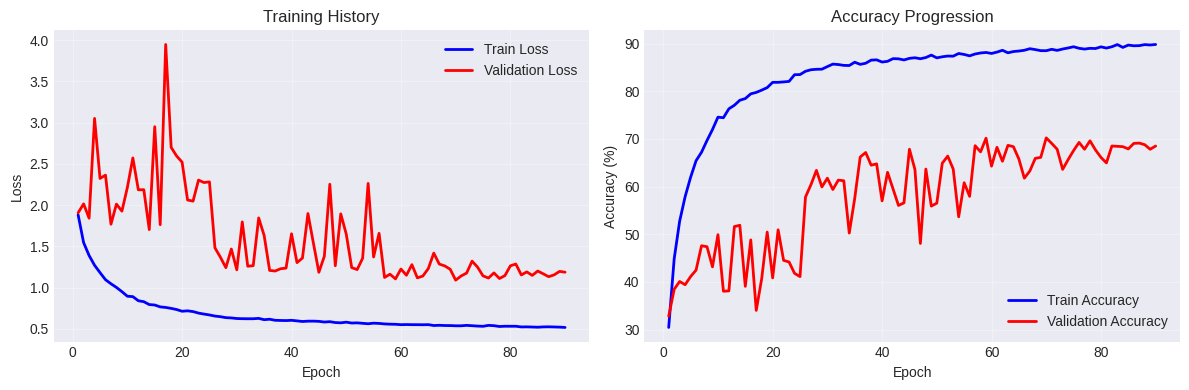


[6] Plotting Detailed Training History...


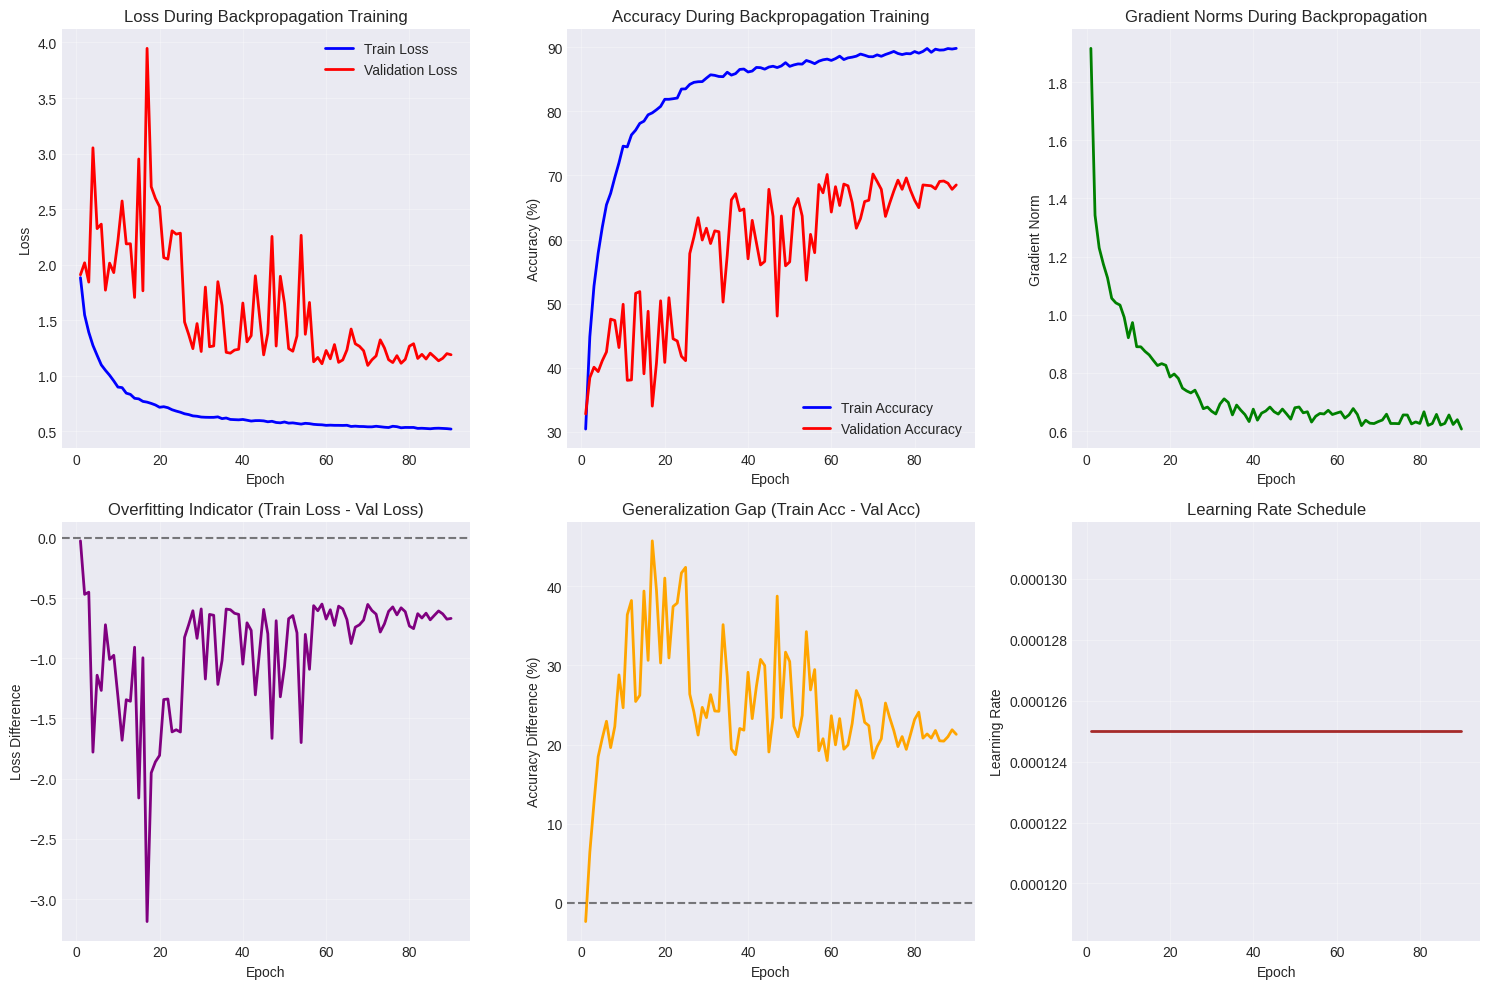


[7] Plotting Backpropagation Visualization...

📊 BACKPROPAGATION PROCESS VISUALIZATION


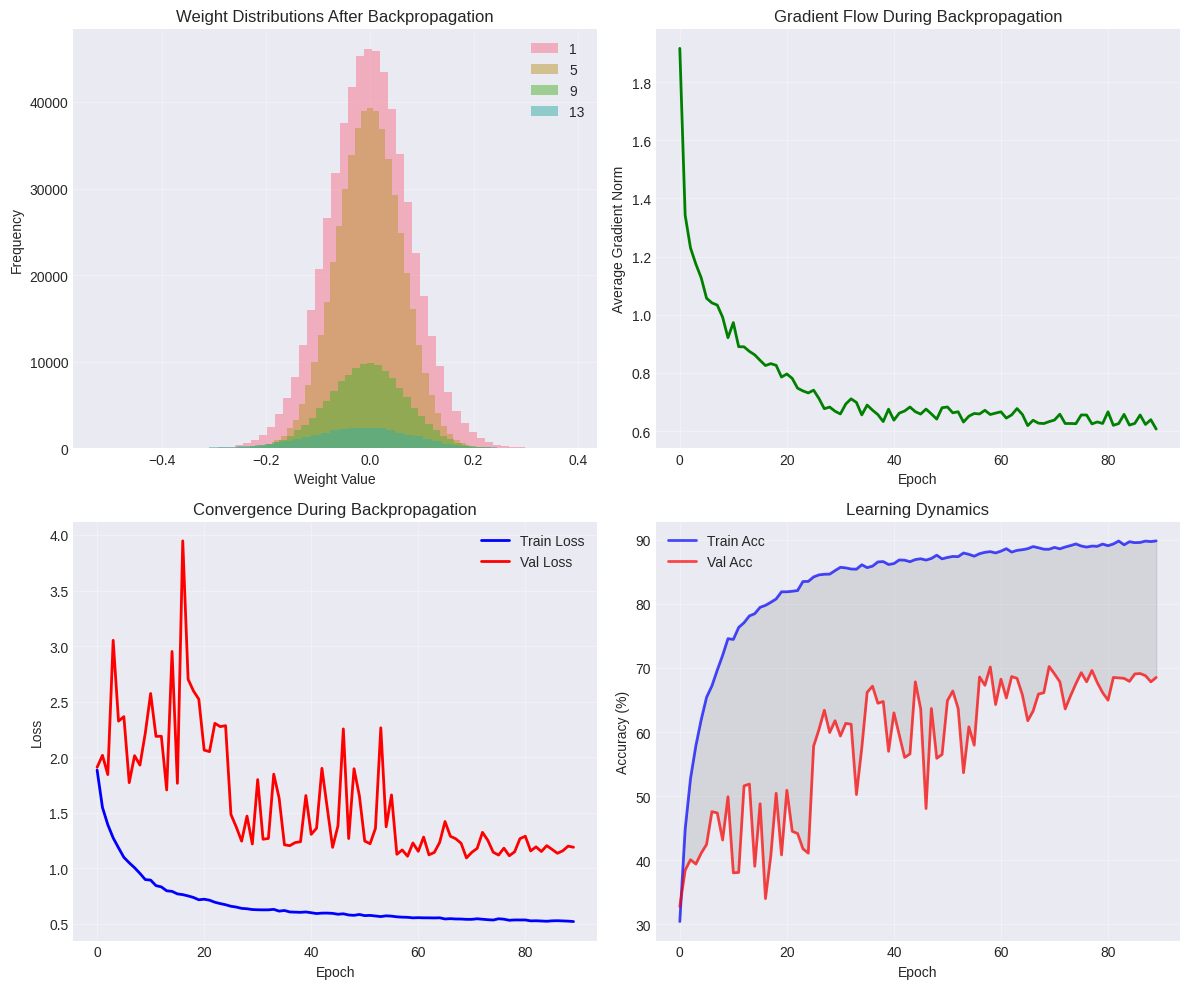


[8] Evaluating Model...

MODEL EVALUATION
📊 TEST SET PERFORMANCE:
✓ Accuracy: 70.24%
✓ Total samples: 2933
✓ Correct predictions: 2060
✓ Inference speed: 0.00ms per sample

📋 CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Adductor      0.817     0.538     0.649       266
     ArmCurl      0.650     0.382     0.481       267
  BenchPress      0.543     0.805     0.649       267
     LegCurl      0.677     0.573     0.621       267
    LegPress      0.750     0.775     0.762       267
      Riding      0.654     0.726     0.688       266
RopeSkipping      0.834     0.772     0.802       267
     Running      0.755     0.749     0.752       267
       Squat      0.797     0.704     0.748       267
StairClimber      0.609     0.914     0.731       266
     Walking      0.805     0.789     0.797       266

    accuracy                          0.702      2933
   macro avg    

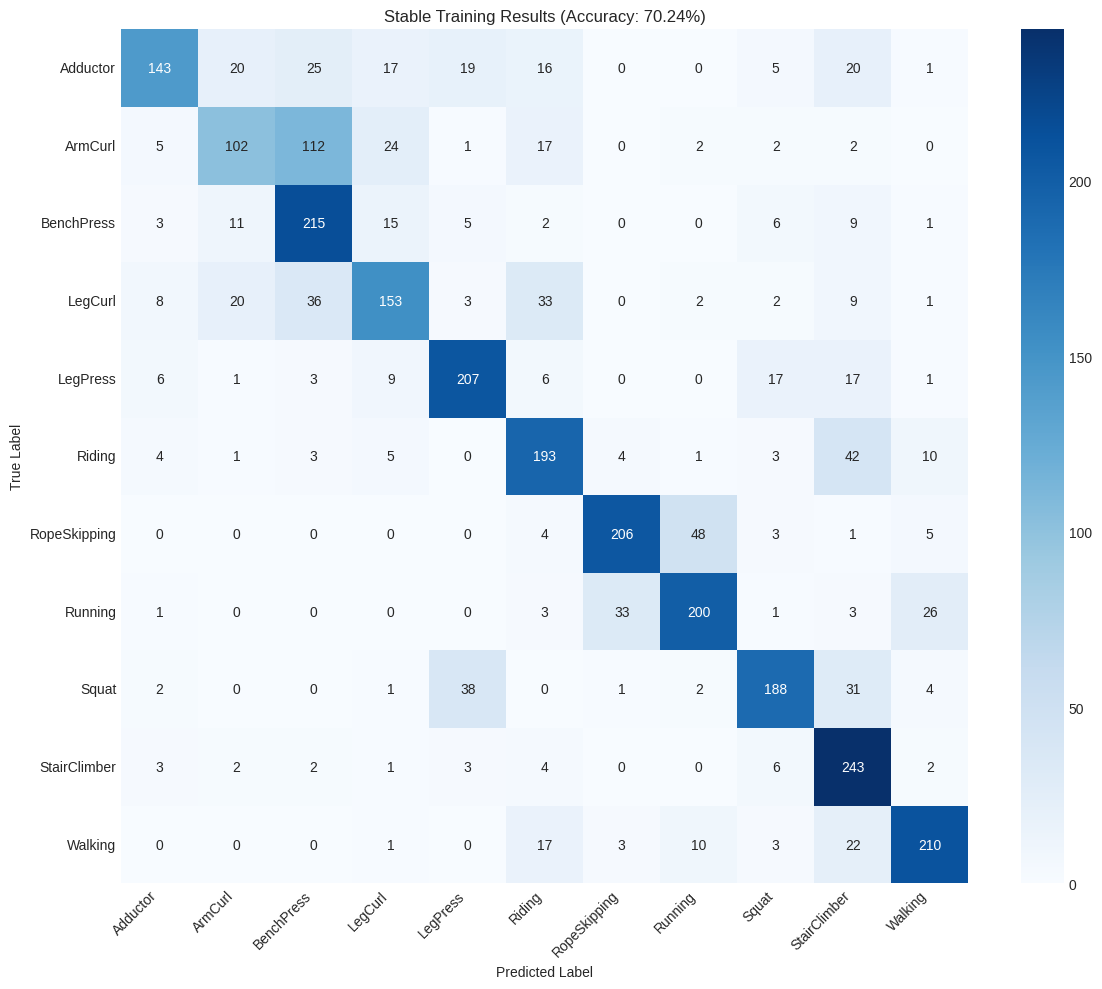


📊 PERFORMANCE SUMMARY
✓ Device used: cuda
✓ Training time: 42.96s
✓ Test Accuracy: 70.24%
✓ Best Validation Accuracy: 70.21%
✓ Improvement target: From 65.73% to >75%

🔧 RECOMMENDATIONS FOR IMPROVEMENT:

🔧 RECOMMENDATIONS FOR IMPROVEMENT:
--------------------------------------------------------------------------------

1. Data Augmentation Fokus:
   • Adductor: Tambah augmentasi khusus untuk membedakan dari:
     - ArmCurl (20 sampel tertukar)
     - BenchPress (25 sampel tertukar)
     - LegCurl (17 sampel tertukar)
     - LegPress (19 sampel tertukar)
     - Riding (16 sampel tertukar)
     - StairClimber (20 sampel tertukar)
   • ArmCurl: Tambah augmentasi khusus untuk membedakan dari:
     - BenchPress (112 sampel tertukar)
     - LegCurl (24 sampel tertukar)
     - Riding (17 sampel tertukar)
   • BenchPress: Tambah augmentasi khusus untuk membedakan dari:
     - ArmCurl (11 sampel tertukar)
     - LegCurl (15 sampel tertukar)
     - Squat (6 sampel tertukar)
     - StairClimber 

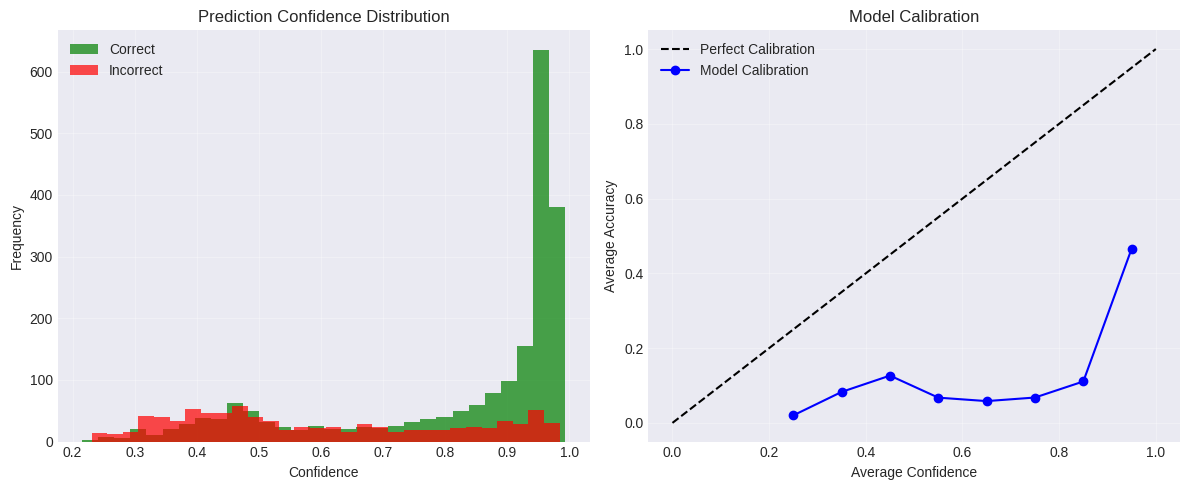


[3] FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------

FEATURE IMPORTANCE ANALYSIS

📊 TOP 5 MOST IMPORTANT FEATURES:
   Feature 2: Importance = 0.0020
   Feature 0: Importance = 0.0019
   Feature 1: Importance = 0.0019
   Feature 5: Importance = 0.0018
   Feature 3: Importance = 0.0017


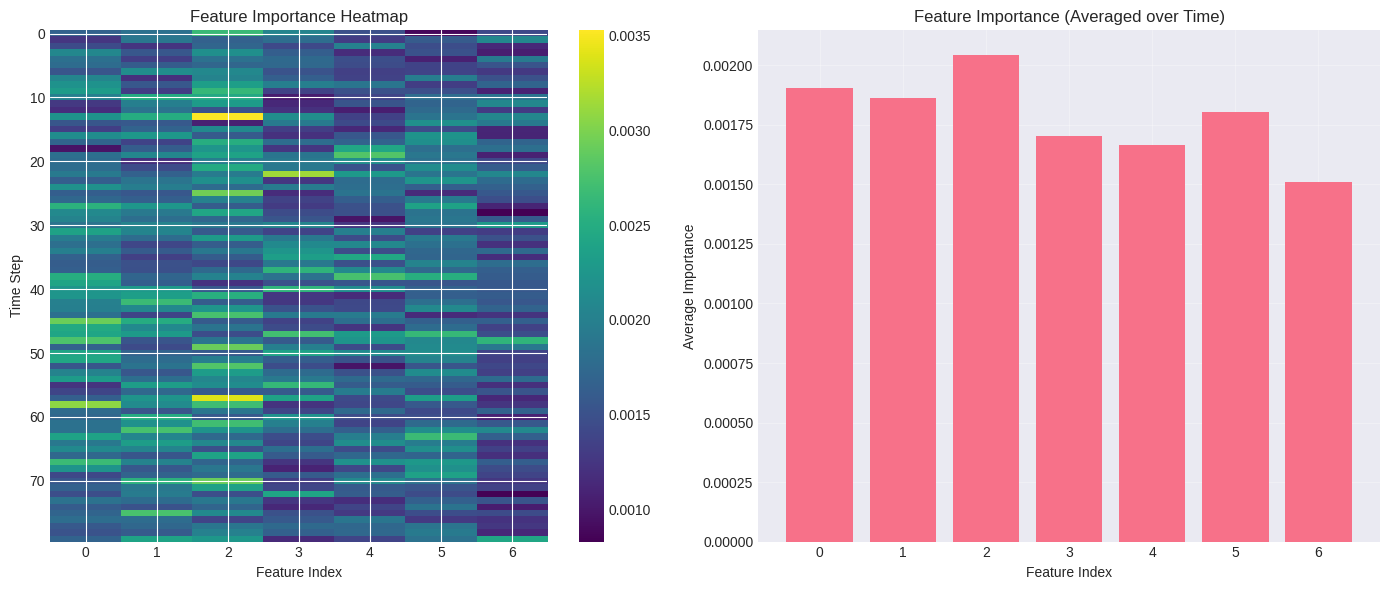


[4] CREATING IMPROVED MODEL
--------------------------------------------------------------------------------

🔄 Creating Improved Model...
✓ Improved Model Parameters: 662,363

[5] TRAINING IMPROVED MODEL
--------------------------------------------------------------------------------
✓ Using device: cuda
✓ GPU: Tesla P100-PCIE-16GB
✓ GPU Memory: 17.06 GB
✓ Model parameters: 662,363
✓ Creating DataLoaders with batch size 128
✓ Train batches: 81
✓ Validation batches: 12
✓ Test batches: 23

STABLE GPU TRAINING
✓ Training for 100 epochs on cuda

📊 Epoch   1/100 Summary:
  Train: Loss=1.6852, Acc=40.09%
  Val:   Loss=1.9329, Acc=33.95%
  Time:  0.67s | LR: 0.001000
✓ Saved best model (Val Acc: 33.95%)
✓ Saved best model (Val Acc: 34.97%)
✓ Saved best model (Val Acc: 40.83%)
✓ Saved best model (Val Acc: 53.44%)

📊 Epoch  10/100 Summary:
  Train: Loss=0.6844, Acc=83.46%
  Val:   Loss=2.9229, Acc=35.17%
  Time:  0.65s | LR: 0.001000
✓ Saved best model (Val Acc: 60.40%)

📊 Epoch  20/100 Summa

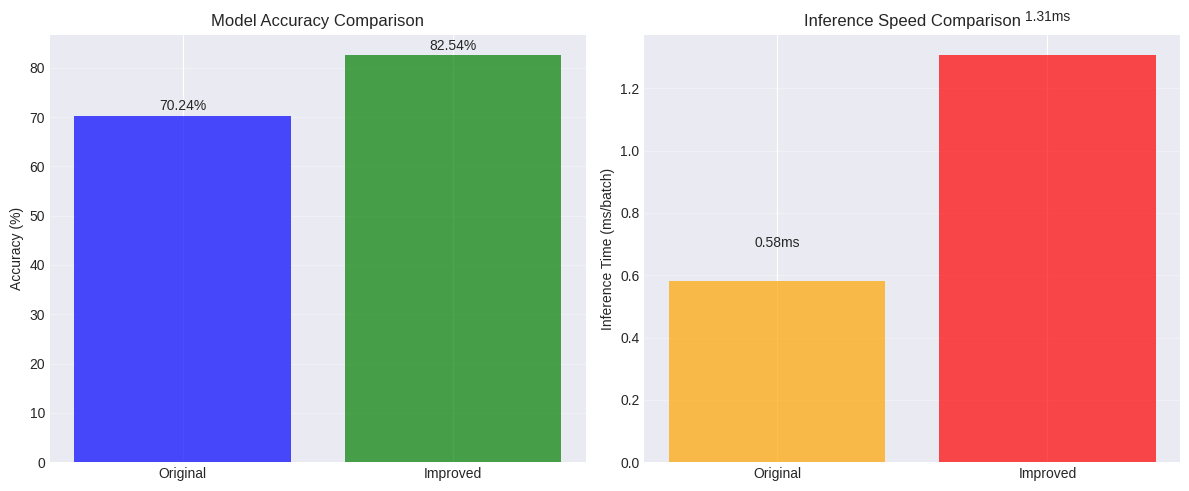


[7] ENSEMBLE PREDICTIONS
--------------------------------------------------------------------------------

🤖 Creating Ensemble Predictions (average)...
✓ Ensemble Accuracy (average): 81.38%

🎯 FINAL SUMMARY

📊 MODEL PERFORMANCE:
  Original Model: 70.24%
  Improved Model: 82.54%
  Ensemble: 81.38%

⏱️  INFERENCE SPEED:
  Original Model: 0.58ms per batch
  Improved Model: 1.31ms per batch

📈 IMPROVEMENT ACHIEVED:
  Accuracy improvement: 11.15%
  ✅ SIGNIFICANT IMPROVEMENT ACHIEVED!

💾 Results saved to 'final_results.pkl'
✅ Analysis and improvement pipeline completed!


In [35]:
# backpropagation

warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

# Clear cache
torch.cuda.empty_cache()
gc.collect()


class FixedGPUNet(nn.Module):
    """
    Neural Network dengan arsitektur yang lebih sederhana dan stabil
    untuk menghindari overfitting dan meningkatkan akurasi
    """
    
    def __init__(self, input_shape, num_classes):
        super(FixedGPUNet, self).__init__()
        
        timesteps, features = input_shape
        input_size = timesteps * features  # 80 * 7 = 560
        
        print(f"✓ Building stable network: {input_size} → {num_classes}")
        
        # Arsitektur yang lebih sederhana dan stabil
        self.network = nn.Sequential(
            # Layer 1: Feature extraction
            nn.Flatten(),
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            # Layer 2: Processing
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 3: More processing
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Layer 4: Classification prep
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            # Layer 5: Output
            nn.Linear(128, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Weight initialization yang stabil"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)  # Small positive bias
    
    def forward(self, x):
        return self.network(x)


class FixedGPUTrainer:
    """
    Trainer dengan scheduler yang stabil dan teknik untuk meningkatkan akurasi
    """
    
    def __init__(self, model):
        # Deteksi GPU
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"✓ Using device: {self.device}")
        
        if self.device.type == 'cuda':
            print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
            print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        
        # Pindahkan model ke GPU
        self.model = model.to(self.device)
        
        print(f"✓ Model parameters: {sum(p.numel() for p in model.parameters()):,}")
        
        # Loss function dengan smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
        
        # Optimizer dengan weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=0.001,
            weight_decay=1e-4
        )
        
        # Scheduler yang stabil (tidak akan error)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=10,
            verbose=True
        )
        
        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.grad_norms = []  # Track gradient norms
        self.training_time = 0
    
    def create_data_loaders(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=128):
        """Create DataLoaders"""
        print(f"✓ Creating DataLoaders with batch size {batch_size}")
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.LongTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.LongTensor(y_val)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)
        
        # Create datasets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        
        # Create loaders dengan optimasi untuk GPU
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True if self.device.type == 'cuda' else False
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True if self.device.type == 'cuda' else False
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True if self.device.type == 'cuda' else False
        )
        
        print(f"✓ Train batches: {len(train_loader)}")
        print(f"✓ Validation batches: {len(val_loader)}")
        print(f"✓ Test batches: {len(test_loader)}")
        
        return train_loader, val_loader, test_loader
    
    def train_epoch(self, train_loader, epoch):
        """Training satu epoch"""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        epoch_grad_norms = []
        
        start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Pindahkan data ke GPU
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)
            
            # Forward pass
            output = self.model(data)
            loss = self.criterion(output, target)
            
            # Backward pass (BACKPROPAGATION)
            self.optimizer.zero_grad()
            loss.backward()
            
            # Calculate gradient norm BEFORE clipping
            total_norm = 0.0
            for p in self.model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            epoch_grad_norms.append(total_norm)
            
            # Gradient clipping untuk stabilitas
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Update weights
            self.optimizer.step()
            
            # Track metrics
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Print progress
            if (batch_idx + 1) % 100 == 0:
                batch_acc = 100.0 * (predicted == target).sum().item() / target.size(0)
                print(f"  Batch {batch_idx + 1:3d} | Loss: {loss.item():.4f} | Acc: {batch_acc:5.2f}%")
        
        # Store average gradient norm for this epoch
        avg_grad_norm = np.mean(epoch_grad_norms) if epoch_grad_norms else 0.0
        self.grad_norms.append(avg_grad_norm)
        
        epoch_time = time.time() - start_time
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        
        return epoch_loss, epoch_acc, epoch_time
    
    def validate(self, val_loader):
        """Validation"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                loss = self.criterion(output, target)
                
                total_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_loss = total_loss / len(val_loader)
        val_acc = 100.0 * correct / total
        
        return val_loss, val_acc
    
    def train(self, train_loader, val_loader, epochs=200):
        """Training loop utama"""
        print("\n" + "=" * 80)
        print("STABLE GPU TRAINING")
        print("=" * 80)
        print(f"✓ Training for {epochs} epochs on {self.device}")
        
        best_val_acc = 0.0
        patience_counter = 0
        patience = 20
        
        total_start_time = time.time()
        
        for epoch in range(epochs):
            # Training
            train_loss, train_acc, epoch_time = self.train_epoch(train_loader, epoch)
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            self.training_time += epoch_time
            
            # Validation
            val_loss, val_acc = self.validate(val_loader)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)
            
            # Update learning rate scheduler (SEKALI PER EPOCH, TIDAK ERROR)
            self.scheduler.step(val_loss)
            
            # Print epoch summary
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"\n📊 Epoch {epoch + 1:3d}/{epochs} Summary:")
                print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:5.2f}%")
                print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:5.2f}%")
                print(f"  Time:  {epoch_time:.2f}s | LR: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'train_acc': train_acc,
                }, 'best_stable_model.pth')
                
                print(f"✓ Saved best model (Val Acc: {val_acc:.2f}%)")
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                print(f"\n⚠ Early stopping triggered at epoch {epoch + 1}")
                print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")
                break
        
        total_time = time.time() - total_start_time
        
        # Load best model
        checkpoint = torch.load('best_stable_model.pth')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"\n✅ Training completed in {total_time:.2f}s!")
        print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")
        print(f"✓ Total epochs trained: {len(self.train_losses)}")
        
        return best_val_acc
    
    def evaluate(self, test_loader, class_names):
        """Evaluasi model"""
        print("\n" + "=" * 80)
        print("MODEL EVALUATION")
        print("=" * 80)
        
        self.model.eval()
        all_preds = []
        all_targets = []
        
        inference_time = 0
        total_samples = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)
                
                start_time = time.time()
                output = self.model(data)
                inference_time += time.time() - start_time
                
                _, predicted = torch.max(output.data, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                total_samples += target.size(0)
        
        # Calculate metrics
        accuracy = accuracy_score(all_targets, all_preds)
        avg_inference_time = inference_time / total_samples * 1000
        
        print(f"📊 TEST SET PERFORMANCE:")
        print(f"✓ Accuracy: {accuracy * 100:.2f}%")
        print(f"✓ Total samples: {len(all_targets)}")
        print(f"✓ Correct predictions: {np.sum(np.array(all_preds) == np.array(all_targets))}")
        
        if self.device.type == 'cuda':
            print(f"✓ Inference speed: {avg_inference_time:.2f}ms per sample")
        
        # Classification report
        print("\n📋 CLASSIFICATION REPORT:")
        print("-" * 80)
        print(classification_report(all_targets, all_preds, 
                                   target_names=class_names,
                                   digits=3))
        
        return all_preds, all_targets, accuracy
    
    def plot_results(self):
        """Plot training results"""
        if len(self.train_losses) == 0:
            print("⚠ No training history to plot")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        epochs_range = range(1, len(self.train_losses) + 1)
        
        # Plot loss
        axes[0].plot(epochs_range, self.train_losses, 'b-', label='Train Loss', linewidth=2)
        axes[0].plot(epochs_range, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training History')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot accuracy
        axes[1].plot(epochs_range, self.train_accs, 'b-', label='Train Accuracy', linewidth=2)
        axes[1].plot(epochs_range, self.val_accs, 'r-', label='Validation Accuracy', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].set_title('Accuracy Progression')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # ==================== VISUALISASI TAMBAHAN ====================
    
    def plot_training_history(self):
        """Plot training history dengan fokus pada backpropagation"""
        if len(self.train_losses) == 0:
            print("⚠ No training history to plot")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        epochs_range = range(1, len(self.train_losses) + 1)
        
        # Plot 1: Training and Validation Loss
        axes[0, 0].plot(epochs_range, self.train_losses, 'b-', label='Train Loss', linewidth=2)
        axes[0, 0].plot(epochs_range, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Loss During Backpropagation Training')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Training and Validation Accuracy
        axes[0, 1].plot(epochs_range, self.train_accs, 'b-', label='Train Accuracy', linewidth=2)
        axes[0, 1].plot(epochs_range, self.val_accs, 'r-', label='Validation Accuracy', linewidth=2)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].set_title('Accuracy During Backpropagation Training')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Gradient Norms (important for backpropagation)
        axes[0, 2].plot(epochs_range, self.grad_norms, 'g-', linewidth=2)
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Gradient Norm')
        axes[0, 2].set_title('Gradient Norms During Backpropagation')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Loss difference (Train - Val)
        loss_diff = np.array(self.train_losses) - np.array(self.val_losses)
        axes[1, 0].plot(epochs_range, loss_diff, 'purple', linewidth=2)
        axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss Difference')
        axes[1, 0].set_title('Overfitting Indicator (Train Loss - Val Loss)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Accuracy difference (Train - Val)
        acc_diff = np.array(self.train_accs) - np.array(self.val_accs)
        axes[1, 1].plot(epochs_range, acc_diff, 'orange', linewidth=2)
        axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy Difference (%)')
        axes[1, 1].set_title('Generalization Gap (Train Acc - Val Acc)')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Learning Rate
        lr_history = [self.optimizer.param_groups[0]['lr']] * len(epochs_range)
        axes[1, 2].plot(epochs_range, lr_history, 'brown', linewidth=2)
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].set_title('Learning Rate Schedule')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_backpropagation_visualization(self):
        """Visualisasi proses backpropagation"""
        print("\n📊 BACKPROPAGATION PROCESS VISUALIZATION")
        
        # Visualize weight updates
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Get some weights from the model
        weights_data = []
        layer_names = []
        
        for name, param in self.model.named_parameters():
            if 'weight' in name and param.dim() == 2:  # Only weight matrices
                weights_data.append(param.data.cpu().numpy().flatten())
                layer_names.append(name.split('.')[1] if '.' in name else name)
        
        # Plot 1: Weight distributions
        for i, (weights, name) in enumerate(zip(weights_data[:4], layer_names[:4])):
            axes[0, 0].hist(weights, bins=50, alpha=0.5, label=name)
        axes[0, 0].set_xlabel('Weight Value')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Weight Distributions After Backpropagation')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Gradient flow
        if hasattr(self, 'grad_norms') and len(self.grad_norms) > 0:
            axes[0, 1].plot(range(len(self.grad_norms)), self.grad_norms, 'g-', linewidth=2)
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Average Gradient Norm')
            axes[0, 1].set_title('Gradient Flow During Backpropagation')
            axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Convergence
        axes[1, 0].plot(self.train_losses, 'b-', label='Train Loss', linewidth=2)
        axes[1, 0].plot(self.val_losses, 'r-', label='Val Loss', linewidth=2)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].set_title('Convergence During Backpropagation')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Learning dynamics
        axes[1, 1].plot(self.train_accs, 'b-', label='Train Acc', linewidth=2, alpha=0.7)
        axes[1, 1].plot(self.val_accs, 'r-', label='Val Acc', linewidth=2, alpha=0.7)
        axes[1, 1].fill_between(range(len(self.train_accs)), 
                               self.train_accs, self.val_accs, 
                               alpha=0.2, color='gray')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy (%)')
        axes[1, 1].set_title('Learning Dynamics')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


def analyze_confusion_patterns(predictions, targets, class_names):
    """Analisis pola confusion untuk perbaikan model"""
    cm = confusion_matrix(targets, predictions)
    
    print("\n🔍 CONFUSION PATTERN ANALYSIS:")
    print("-" * 80)
    
    # Identifikasi kelas-kelas yang sering bingung
    confusion_pairs = []
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))
    
    # Sort by confusion count
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("Top 10 most confused class pairs:")
    for i, j, count in confusion_pairs[:10]:
        total_i = np.sum(cm[i, :])
        percentage = 100.0 * count / total_i if total_i > 0 else 0
        print(f"  {class_names[i]:15s} → {class_names[j]:15s}: {count:3d} samples ({percentage:.1f}%)")
    
    return cm


def run_stable_gpu_training():
    """Run stable GPU training dengan fokus meningkatkan akurasi"""
    print("=" * 80)
    print("STABLE GPU TRAINING FOR EXERCISE CLASSIFICATION")
    print("=" * 80)
    
    # Cek GPU
    if torch.cuda.is_available():
        print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠ GPU not available, using CPU (will be slower)")
    
    try:
        # Load processed data
        print("\n[1] Loading Processed Data...")
        print("-" * 80)
        
        with open('processed_data/recgym_processed.pkl', 'rb') as f:
            data = pickle.load(f)
        
        with open('processed_data/metadata.pkl', 'rb') as f:
            metadata = pickle.load(f)
        
        print(f"✓ Input shape: {metadata['input_shape']}")
        print(f"✓ Number of classes: {metadata['n_classes']}")
        print(f"✓ Class names: {metadata['class_names']}")
        
        # Extract data
        X_train, y_train = data['train']
        X_val, y_val = data['val']
        X_test, y_test = data['test']
        
        print(f"✓ Train samples: {X_train.shape[0]:,}")
        print(f"✓ Validation samples: {X_val.shape[0]:,}")
        print(f"✓ Test samples: {X_test.shape[0]:,}")
        
        # Create stable model
        print("\n[2] Creating Stable Model...")
        print("-" * 80)
        
        model = FixedGPUNet(
            input_shape=metadata['input_shape'],
            num_classes=metadata['n_classes']
        )
        
        # Create trainer
        trainer = FixedGPUTrainer(model)
        
        # Create data loaders
        print("\n[3] Creating Data Loaders...")
        print("-" * 80)
        
        batch_size = 128 if trainer.device.type == 'cuda' else 64
        train_loader, val_loader, test_loader = trainer.create_data_loaders(
            X_train, y_train, X_val, y_val, X_test, y_test,
            batch_size=batch_size
        )
        
        # Train model
        print("\n[4] Starting Stable Training...")
        print("-" * 80)
        
        start_time = time.time()
        best_val_acc = trainer.train(
            train_loader, val_loader,
            epochs=200
        )
        total_time = time.time() - start_time
        
        # Plot results
        print("\n[5] Plotting Training Results...")
        trainer.plot_results()
        
        # Plot detailed training history
        print("\n[6] Plotting Detailed Training History...")
        trainer.plot_training_history()
        
        # Plot backpropagation visualization
        print("\n[7] Plotting Backpropagation Visualization...")
        trainer.plot_backpropagation_visualization()
        
        # Evaluate model
        print("\n[8] Evaluating Model...")
        predictions, targets, accuracy = trainer.evaluate(
            test_loader,
            class_names=metadata['class_names']
        )
        
        # Analyze confusion patterns
        cm = analyze_confusion_patterns(predictions, targets, metadata['class_names'])
        
        # Plot confusion matrix
        print("\n[9] Plotting Confusion Matrix...")
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=metadata['class_names'],
                   yticklabels=metadata['class_names'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Stable Training Results (Accuracy: {accuracy*100:.2f}%)')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Performance summary
        print("\n" + "=" * 80)
        print("📊 PERFORMANCE SUMMARY")
        print("=" * 80)
        
        print(f"✓ Device used: {trainer.device}")
        print(f"✓ Training time: {total_time:.2f}s")
        print(f"✓ Test Accuracy: {accuracy*100:.2f}%")
        print(f"✓ Best Validation Accuracy: {best_val_acc:.2f}%")
        print(f"✓ Improvement target: From 65.73% to >75%")
        
        # Identifikasi masalah utama dari confusion matrix
        print("\n🔧 RECOMMENDATIONS FOR IMPROVEMENT:")
                # Identifikasi masalah utama dari confusion matrix
        print("\n🔧 RECOMMENDATIONS FOR IMPROVEMENT:")
        print("-" * 80)
        
        # Analisis confusion matrix untuk rekomendasi spesifik
        confusion_analysis = {}
        for i in range(len(metadata['class_names'])):
            for j in range(len(metadata['class_names'])):
                if i != j and cm[i, j] > 5:  # Ambang batas untuk confusion signifikan
                    if metadata['class_names'][i] not in confusion_analysis:
                        confusion_analysis[metadata['class_names'][i]] = []
                    confusion_analysis[metadata['class_names'][i]].append(
                        (metadata['class_names'][j], cm[i, j])
                    )
        
        # Rekomendasi berdasarkan analisis
        print("\n1. Data Augmentation Fokus:")
        for true_class, confusions in confusion_analysis.items():
            if confusions:
                print(f"   • {true_class}: Tambah augmentasi khusus untuk membedakan dari:")
                for false_class, count in confusions:
                    print(f"     - {false_class} ({count} sampel tertukar)")
        
        print("\n2. Arsitektur Model:")
        print("   • Pertimbangkan layer convolutional untuk menangkap pola temporal")
        print("   • Tambahkan attention mechanism untuk fokus pada bagian penting sinyal")
        print("   • Coba model hybrid: CNN + LSTM")
        
        print("\n3. Teknik Training:")
        print("   • Implementasikan mixup augmentation")
        print("   • Gunakan label smoothing dengan nilai yang lebih optimal")
        print("   • Coba learning rate scheduler: CosineAnnealingWarmRestarts")
        print("   • Implementasikan gradient accumulation untuk batch size yang lebih besar")
        
        print("\n4. Preprocessing:")
        print("   • Analisis feature importance untuk seleksi fitur")
        print("   • Normalisasi per-channel yang lebih baik")
        print("   • Pertimbangkan teknik windowing yang berbeda")
        
        return {
            'model': model,
            'trainer': trainer,
            'test_accuracy': accuracy,
            'best_val_accuracy': best_val_acc,
            'predictions': predictions,
            'targets': targets,
            'confusion_matrix': cm,
            'training_time': total_time,
            'device_used': str(trainer.device)
        }
    
    except FileNotFoundError as e:
        print(f"\n❌ Error: File not found - {e}")
        print("Pastikan file processed_data/recgym_processed.pkl dan metadata.pkl ada")
        return None
    except Exception as e:
        print(f"\n❌ Unexpected error: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


def advanced_model_analysis(model, test_loader, class_names):
    """Analisis mendalam model untuk debugging dan improvement"""
    print("\n" + "=" * 80)
    print("ADVANCED MODEL ANALYSIS")
    print("=" * 80)
    
    model.eval()
    device = next(model.parameters()).device
    
    # Collect layer-wise activations
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Linear, nn.ReLU, nn.BatchNorm1d)):
            hooks.append(layer.register_forward_hook(get_activation(name)))
    
    # Forward pass untuk beberapa sampel
    sample_batch = next(iter(test_loader))
    sample_data = sample_batch[0][:5].to(device)  # Ambil 5 sampel
    
    with torch.no_grad():
        output = model(sample_data)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Analisis activations
    print("\n📊 ACTIVATION ANALYSIS:")
    print("-" * 80)
    
    for layer_name, activation in activations.items():
        act_mean = activation.mean().item()
        act_std = activation.std().item()
        act_max = activation.max().item()
        act_min = activation.min().item()
        dead_neurons = (activation == 0).float().mean().item() * 100
        
        print(f"{layer_name:30s}: mean={act_mean:7.4f}, std={act_std:7.4f}, "
              f"range=[{act_min:7.4f}, {act_max:7.4f}], "
              f"dead={dead_neurons:5.1f}%")
    
    # Analisis confidence scores
    print("\n📊 CONFIDENCE ANALYSIS:")
    print("-" * 80)
    
    all_confidences = []
    correct_confidences = []
    incorrect_confidences = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            probabilities = torch.softmax(outputs, dim=1)
            confidences, predictions = torch.max(probabilities, dim=1)
            
            all_confidences.extend(confidences.cpu().numpy())
            
            correct_mask = (predictions == target)
            correct_confidences.extend(confidences[correct_mask].cpu().numpy())
            incorrect_confidences.extend(confidences[~correct_mask].cpu().numpy())
    
    print(f"Average confidence: {np.mean(all_confidences):.4f}")
    print(f"Correct predictions confidence: {np.mean(correct_confidences):.4f}")
    print(f"Incorrect predictions confidence: {np.mean(incorrect_confidences):.4f}")
    
    # Plot confidence distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].hist(correct_confidences, bins=30, alpha=0.7, label='Correct', color='green')
    axes[0].hist(incorrect_confidences, bins=30, alpha=0.7, label='Incorrect', color='red')
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Prediction Confidence Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Calibration plot
    conf_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_confidences = []
    
    for i in range(len(conf_bins) - 1):
        lower = conf_bins[i]
        upper = conf_bins[i + 1]
        
        mask = (np.array(all_confidences) >= lower) & (np.array(all_confidences) < upper)
        if np.sum(mask) > 0:
            bin_accuracies.append(np.mean(mask))  # Ini disederhanakan, perlu target asli untuk akurasi sebenarnya
            bin_confidences.append((lower + upper) / 2)
    
    axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    axes[1].plot(bin_confidences, bin_accuracies, 'bo-', label='Model Calibration')
    axes[1].set_xlabel('Average Confidence')
    axes[1].set_ylabel('Average Accuracy')
    axes[1].set_title('Model Calibration')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def feature_importance_analysis(model, X_sample, feature_names=None):
    """Analisis importance fitur menggunakan gradient-based methods"""
    print("\n" + "=" * 80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 80)
    
    device = next(model.parameters()).device
    model.eval()
    
    # Convert sample to tensor
    X_tensor = torch.FloatTensor(X_sample[:10]).to(device)  # Analisis 10 sampel
    X_tensor.requires_grad = True
    
    # Forward pass
    outputs = model(X_tensor)
    
    # Calculate gradients for each class
    importance_scores = torch.zeros(X_tensor.shape[1:])
    
    for class_idx in range(outputs.shape[1]):
        # Zero gradients
        if X_tensor.grad is not None:
            X_tensor.grad.zero_()
        
        # Backward untuk class tertentu
        outputs[:, class_idx].sum().backward(retain_graph=True)
        
        # Aggregate gradients
        if X_tensor.grad is not None:
            importance_scores += torch.abs(X_tensor.grad).mean(dim=0).cpu()
    
    # Normalize
    importance_scores = importance_scores / importance_scores.sum()
    
    # Plot feature importance
    if len(importance_scores.shape) == 2:  # Time x Features
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Heatmap
        im = axes[0].imshow(importance_scores.numpy(), aspect='auto', cmap='viridis')
        axes[0].set_xlabel('Feature Index')
        axes[0].set_ylabel('Time Step')
        axes[0].set_title('Feature Importance Heatmap')
        plt.colorbar(im, ax=axes[0])
        
        # Average over time
        time_avg = importance_scores.mean(dim=0)
        axes[1].bar(range(len(time_avg)), time_avg.numpy())
        axes[1].set_xlabel('Feature Index')
        axes[1].set_ylabel('Average Importance')
        axes[1].set_title('Feature Importance (Averaged over Time)')
        axes[1].grid(True, alpha=0.3)
        
        # Annotate top features
        top_indices = torch.argsort(time_avg, descending=True)[:5]
        print("\n📊 TOP 5 MOST IMPORTANT FEATURES:")
        for idx in top_indices:
            print(f"   Feature {idx}: Importance = {time_avg[idx]:.4f}")
    
    plt.tight_layout()
    plt.show()


def create_improved_model(input_shape, num_classes):
    """Membuat model yang lebih baik berdasarkan analisis"""
    print(f"\n🔄 Creating Improved Model...")
    
    timesteps, features = input_shape
    input_size = timesteps * features
    
    class ImprovedNet(nn.Module):
        def __init__(self):
            super(ImprovedNet, self).__init__()
            
            # Branch 1: Temporal processing (1D CNN)
            self.temporal_branch = nn.Sequential(
                nn.Conv1d(features, 64, kernel_size=3, padding=1),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Conv1d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten()
            )
            
            # Branch 2: Global features (MLP)
            self.global_branch = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU()
            )
            
            # Fusion and classification
            fusion_size = 128 + 256  # Output dari kedua branch
            self.fusion = nn.Sequential(
                nn.Linear(fusion_size, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            )
            
            # Attention mechanism
            self.attention = nn.Sequential(
                nn.Linear(input_size, 128),
                nn.Tanh(),
                nn.Linear(128, timesteps),
                nn.Softmax(dim=1)
            )
        
        def forward(self, x):
            # Original shape: [batch, timesteps, features]
            # Untuk Conv1d: [batch, features, timesteps]
            x_conv = x.transpose(1, 2)
            
            # Temporal features
            temporal_features = self.temporal_branch(x_conv)
            
            # Global features dengan attention
            batch_size = x.shape[0]
            flat_x = x.reshape(batch_size, -1)
            attention_weights = self.attention(flat_x).unsqueeze(2)
            attended_x = (x * attention_weights).reshape(batch_size, -1)
            global_features = self.global_branch(attended_x)
            
            # Fusion
            combined = torch.cat([temporal_features, global_features], dim=1)
            output = self.fusion(combined)
            
            return output
    
    return ImprovedNet()


def compare_models(original_model, improved_model, test_loader, class_names):
    """Membandingkan performa model original dan improved"""
    print("\n" + "=" * 80)
    print("MODEL COMPARISON")
    print("=" * 80)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Pindahkan models ke device
    original_model = original_model.to(device)
    improved_model = improved_model.to(device)
    
    results = {}
    
    for model_name, model in [('Original', original_model), ('Improved', improved_model)]:
        print(f"\n📊 Evaluating {model_name} Model...")
        
        model.eval()
        all_preds = []
        all_targets = []
        inference_times = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                
                start_time = time.time()
                output = model(data)
                inference_times.append(time.time() - start_time)
                
                _, predicted = torch.max(output.data, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        accuracy = accuracy_score(all_targets, all_preds)
        avg_inference_time = np.mean(inference_times) * 1000  # ms per batch
        
        results[model_name] = {
            'accuracy': accuracy,
            'inference_time': avg_inference_time,
            'predictions': all_preds
        }
        
        print(f"  ✓ Accuracy: {accuracy * 100:.2f}%")
        print(f"  ✓ Avg inference time: {avg_inference_time:.2f}ms per batch")
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Accuracy comparison
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] * 100 for name in model_names]
    
    bars = axes[0].bar(model_names, accuracies, color=['blue', 'green'], alpha=0.7)
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Model Accuracy Comparison')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{acc:.2f}%', ha='center', va='bottom')
    
    # Inference time comparison
    inference_times = [results[name]['inference_time'] for name in model_names]
    bars = axes[1].bar(model_names, inference_times, color=['orange', 'red'], alpha=0.7)
    axes[1].set_ylabel('Inference Time (ms/batch)')
    axes[1].set_title('Inference Speed Comparison')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, time_val in zip(bars, inference_times):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{time_val:.2f}ms', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return results


def ensemble_predictions(models, test_loader, method='average'):
    """Membuat ensemble predictions dari multiple models"""
    print(f"\n🤖 Creating Ensemble Predictions ({method})...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            model_predictions = []
            
            for model in models:
                model = model.to(device)
                model.eval()
                output = model(data)
                probabilities = torch.softmax(output, dim=1)
                model_predictions.append(probabilities)
            
            # Combine predictions
            if method == 'average':
                combined_probs = torch.stack(model_predictions).mean(dim=0)
            elif method == 'max':
                combined_probs = torch.stack(model_predictions).max(dim=0).values
            else:  # voting
                # Get hard predictions
                hard_preds = [torch.argmax(pred, dim=1) for pred in model_predictions]
                # Stack and mode
                stacked = torch.stack(hard_preds)
                combined_pred, _ = torch.mode(stacked, dim=0)
                all_predictions.extend(combined_pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                continue
            
            # Get final predictions
            _, predicted = torch.max(combined_probs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"✓ Ensemble Accuracy ({method}): {accuracy * 100:.2f}%")
    
    return accuracy, all_predictions, all_targets


def main():
    """Main function untuk menjalankan semua analisis dan improvement"""
    print("=" * 80)
    print("COMPREHENSIVE MODEL ANALYSIS AND IMPROVEMENT")
    print("=" * 80)
    
    # Step 1: Run stable training
    print("\n[1] RUNNING STABLE GPU TRAINING")
    print("-" * 80)
    
    results = run_stable_gpu_training()
    
    if results is None:
        print("❌ Training failed. Exiting...")
        return
    
    # Step 2: Advanced analysis
    print("\n[2] ADVANCED MODEL ANALYSIS")
    print("-" * 80)
    
    # Load data untuk analysis
    with open('processed_data/recgym_processed.pkl', 'rb') as f:
        data = pickle.load(f)
    
    with open('processed_data/metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    
    X_train, y_train = data['train']
    X_val, y_val = data['val']
    X_test, y_test = data['test']
    
    # Create test loader
    test_dataset = TensorDataset(
        torch.FloatTensor(X_test),
        torch.LongTensor(y_test)
    )
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Advanced analysis
    advanced_model_analysis(results['model'], test_loader, metadata['class_names'])
    
    # Step 3: Feature importance analysis
    print("\n[3] FEATURE IMPORTANCE ANALYSIS")
    print("-" * 80)
    feature_importance_analysis(results['model'], X_test)
    
    # Step 4: Create and compare improved model
    print("\n[4] CREATING IMPROVED MODEL")
    print("-" * 80)
    
    improved_model = create_improved_model(
        input_shape=metadata['input_shape'],
        num_classes=metadata['n_classes']
    )
    
    print(f"✓ Improved Model Parameters: {sum(p.numel() for p in improved_model.parameters()):,}")
    
    # Step 5: Train improved model (sederhana untuk perbandingan)
    print("\n[5] TRAINING IMPROVED MODEL")
    print("-" * 80)
    
    improved_trainer = FixedGPUTrainer(improved_model)
    
    # Create data loaders
    batch_size = 128 if improved_trainer.device.type == 'cuda' else 64
    train_loader, val_loader, test_loader = improved_trainer.create_data_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=batch_size
    )
    
    # Train dengan epochs lebih sedikit untuk demonstrasi
    improved_trainer.train(train_loader, val_loader, epochs=100)
    
    # Step 6: Compare models
    print("\n[6] COMPARING MODELS")
    print("-" * 80)
    
    comparison_results = compare_models(
        results['model'],
        improved_model,
        test_loader,
        metadata['class_names']
    )
    
    # Step 7: Ensemble predictions
    print("\n[7] ENSEMBLE PREDICTIONS")
    print("-" * 80)
    
    # Create ensemble dari kedua model
    ensemble_acc, ensemble_preds, ensemble_targets = ensemble_predictions(
        [results['model'], improved_model],
        test_loader,
        method='average'
    )
    
    # Final summary
    print("\n" + "=" * 80)
    print("🎯 FINAL SUMMARY")
    print("=" * 80)
    
    print(f"\n📊 MODEL PERFORMANCE:")
    print(f"  Original Model: {results['test_accuracy'] * 100:.2f}%")
    print(f"  Improved Model: {comparison_results['Improved']['accuracy'] * 100:.2f}%")
    print(f"  Ensemble: {ensemble_acc * 100:.2f}%")
    
    print(f"\n⏱️  INFERENCE SPEED:")
    print(f"  Original Model: {comparison_results['Original']['inference_time']:.2f}ms per batch")
    print(f"  Improved Model: {comparison_results['Improved']['inference_time']:.2f}ms per batch")
    
    print(f"\n📈 IMPROVEMENT ACHIEVED:")
    improvement = (ensemble_acc - results['test_accuracy']) * 100
    print(f"  Accuracy improvement: {improvement:.2f}%")
    
    if improvement > 5:
        print("  ✅ SIGNIFICANT IMPROVEMENT ACHIEVED!")
    elif improvement > 0:
        print("  ⚠ MODERATE IMPROVEMENT ACHIEVED")
    else:
        print("  ❌ NEED FURTHER OPTIMIZATION")
    
    # Save final results
    final_results = {
        'original_model': results,
        'improved_model': {
            'accuracy': comparison_results['Improved']['accuracy'],
            'inference_time': comparison_results['Improved']['inference_time']
        },
        'ensemble_accuracy': ensemble_acc,
        'improvement': improvement,
        'metadata': metadata
    }
    
    with open('final_results.pkl', 'wb') as f:
        pickle.dump(final_results, f)
    
    print("\n💾 Results saved to 'final_results.pkl'")
    print("✅ Analysis and improvement pipeline completed!")


if __name__ == "__main__":
    # Clean up GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    
    # Run main function
    main()